In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling1D, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise, Embedding, multiply, concatenate, add
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.model_selection import train_test_split
from textwrap import wrap

In [3]:
tf.__version__

'2.1.0'

In [4]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [5]:
def load_image_caption_dict():
    caption_dict = None
    with open('./bert/embeddedcaptions.pickle', 'rb') as f:
        return pickle.load(f)
    
caption_dict = load_image_caption_dict()

def load_caption_text_dict():
    caption_dict = None
    with open('./bert/captions.pickle', 'rb') as f:
        return pickle.load(f)
    
caption_text_dict = load_caption_text_dict()

In [18]:
train_imgs = []
train_classes = []
train_captions = []
caption_text = []
class_index = 0
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned-named/", topdown=False):
    print(f'{len(files)} samples in class {class_index}, ({root})')
    for name in files:
        train_imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR))
        train_classes.append(class_index)
        train_captions.append(caption_dict[name.split('.')[0]+'.txt'][0]) # Just using the first of 10 captions for now
        caption_text.append(caption_text_dict[name.split('.')[0]+'.txt'][0]) # Just using the first of 10 captions for now
    class_index += 1
train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5
train_imgs = train_imgs.astype(np.float32)
train_classes = np.array(train_classes)
train_captions = np.array(train_captions)

60 samples in class 0, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/001.Black_footed_Albatross)
60 samples in class 1, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/002.Laysan_Albatross)
58 samples in class 2, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/003.Sooty_Albatross)
60 samples in class 3, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/004.Groove_billed_Ani)
44 samples in class 4, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/005.Crested_Auklet)
41 samples in class 5, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/006.Least_Auklet)
53 samples in class 6, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/007.Parakeet_Auklet)
48 samples in class 7, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/008.Rhinoceros_Auklet)
59 samples in class 8, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/009.Brewer_Blackbird)
60 samples in class 9, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/010.Red_winged_Blackbird)
60 samples in class 10, (./CUB_200_2011/CUB_20

60 samples in class 93, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/094.White_breasted_Nuthatch)
60 samples in class 94, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/095.Baltimore_Oriole)
60 samples in class 95, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/096.Hooded_Oriole)
59 samples in class 96, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/097.Orchard_Oriole)
60 samples in class 97, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/098.Scott_Oriole)
60 samples in class 98, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/099.Ovenbird)
60 samples in class 99, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/100.Brown_Pelican)
50 samples in class 100, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/101.White_Pelican)
60 samples in class 101, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/102.Western_Wood_Pewee)
60 samples in class 102, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/103.Sayornis)
60 samples in class 103, (./CUB_200_2011/CUB_200_2011/image

59 samples in class 180, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/181.Worm_eating_Warbler)
60 samples in class 181, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/182.Yellow_Warbler)
60 samples in class 182, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/183.Northern_Waterthrush)
60 samples in class 183, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/184.Louisiana_Waterthrush)
60 samples in class 184, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/185.Bohemian_Waxwing)
60 samples in class 185, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/186.Cedar_Waxwing)
50 samples in class 186, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/187.American_Three_toed_Woodpecker)
60 samples in class 187, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/188.Pileated_Woodpecker)
60 samples in class 188, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/189.Red_bellied_Woodpecker)
58 samples in class 189, (./CUB_200_2011/CUB_200_2011/images-cleaned-named/190.Red_cockaded_Woodp

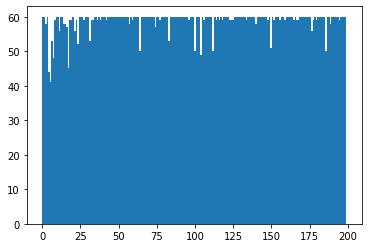

(11788, 64, 64, 3)


In [7]:
plt.hist(train_classes, bins=200)
plt.show()
assert(len(train_imgs) == len(train_classes))
print(train_imgs.shape)

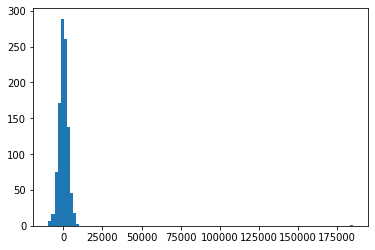

929
18.448483


In [8]:
plt.hist(np.sum(train_captions, axis=0), bins=100)
plt.show()
print(np.argmax(np.sum(train_captions, axis=0)))
print(train_captions[2786][929])

In [9]:
def create_simple_attrs(attrs):
    # Structure is like so: [0-14:color, 15-19:size, 20-33:shape]

    simple_attrs = np.zeros((attrs.shape[0], 34))
    
    # Color
    simple_attrs[:, 0:15] = attrs[:, 248:263]
    
    simple_attrs = np.clip(simple_attrs, a_min=0, a_max=1)
    
    
    # Size and shape
    simple_attrs[:, 15:34] = attrs[:, 217:236]
    
    return simple_attrs


In [10]:
def create_even_simpler_attrs(attrs):
    # Structure is like so: [0-4:color, 5-7:size, 8-9:shape]
    
    simplest_attrs = np.zeros((attrs.shape[0], 10))
    
    simplest_attrs[:, 0] = attrs[:, 1] # Brown
    simplest_attrs[:, 1] = attrs[:, 5] # Grey
    simplest_attrs[:, 2] = attrs[:, 11] # Black
    simplest_attrs[:, 3] = attrs[:, 12] # White
    simplest_attrs[:, 4] = np.clip(np.sum(attrs[:, [0, 2, 3, 4, 6, 7, 8, 9, 10, 13, 14]], axis=1), a_min=0, a_max=1) # Other
    
    simplest_attrs[:, 5] = attrs[:, 19] # Smallest
    simplest_attrs[:, 6] = attrs[:, 16] # Small
    simplest_attrs[:, 7] = np.clip(np.sum(attrs[:, [15, 17, 18]], axis=1), a_min=0, a_max=1) # Large
    
    simplest_attrs[:, 8] = attrs[:, 33] # Perching-like
    simplest_attrs[:, 9] = np.clip(np.sum(attrs[:, [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]], axis=1), a_min=0, a_max=1) # Not perching-like
    
    return simplest_attrs

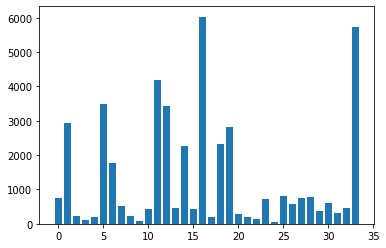

In [11]:
def load_image_attributes():
    train_attrs = np.zeros((train_imgs.shape[0], 312))
    with open('./CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            
            # For now we don't care about attribute certainty, just if it is present.
            try:
                split = line.split()
                img_id = int(split[0])
                assert(img_id > 0)
                assert(img_id <= 11788)
                attr_id = int(split[1])
                assert(attr_id > 0)
                assert(attr_id <= 312)
                is_present = int(split[2])
                assert(is_present == 0 or is_present == 1)
            except: 
                print(line)
                print(line.split())
                return
            
            train_attrs[img_id-1, attr_id-1] = is_present
    return train_attrs

train_attrs = load_image_attributes().astype('float32')
train_attrs = create_simple_attrs(train_attrs)
plt.bar([x for x in range(34)], np.sum(train_attrs, axis=0))
plt.show()
# train_attrs = create_even_simpler_attrs(train_attrs)
train_attrs = train_attrs.astype(np.float32)

In [12]:
# Distribution attributes are too entangled to flatten by subsampling, and also most likely by supersampling.

# np.random.seed(0)

# threshold = 1000

# common_attr_indices = np.where(np.sum(train_attrs, axis=0) > threshold)[0]
# print(common_attr_indices)

# while len(np.where(np.sum(train_attrs, axis=0) > threshold)[0]) > 0:
#     common_attr_indices = np.where(np.sum(train_attrs, axis=0) > threshold)[0]
#     common_attr_ratios = threshold / (np.sum(train_attrs, axis=0)[common_attr_indices]) # ratio of each common to the threshold
#     i = np.argmax(common_attr_ratios)
    
#     print(common_attr_indices)
#     print(common_attr_ratios)
    
#     if len(common_attr_indices) == 0:
#         break
    
#     print(i, len(common_attr_indices))
#     current_common_index = common_attr_indices[i]
    
#     indices = np.where(train_attrs[:, current_common_index] > 0)
#     keepprob = common_attr_ratios[i]
#     keptindicies = np.random.choice([x for x in range(len(train_attrs))], int(keepprob * len(train_attrs)))    
    
#     train_attrs = train_attrs[keptindicies]
#     train_imgs = train_imgs[keptindicies]
#     train_classes = train_classes[keptindicies]
#     train_captions = train_captions[keptindicies]
#     caption_text = [caption_text[x] for x in keptindicies]
#     plt.bar([x for x in range(34)], np.sum(train_attrs, axis=0))
#     plt.show()


In [12]:
def make_caption_autoencoder(attribute_shape):
    caption_shape = 1024
    captions_in = Input(shape=(caption_shape))
    
    x = Reshape((caption_shape, 1))(captions_in)
    
    x = Conv1D(16, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    
    x = Conv1D(32, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    
    x = Conv1D(64, 3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    
#     x = Dropout(0.5)(x)
    
    x = Dense(attribute_shape, name='attr_out', activation='sigmoid')(x)
    attr_out = x
    
    x = Dense(8192)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    
    x = Reshape((128, 64))(x)

    x = UpSampling1D()(x)
    x = Conv1D(64, 3, strides=1, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(32, 3, strides=1, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(16, 3, strides=1, padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    
    x = Conv1D(1, 3, strides=1, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Flatten(name='caption_out')(x)
    
#     x = Dense(1024, name='caption_out')(x)
    
    return Model(captions_in, [x, attr_out])

In [13]:
autoencoder = make_caption_autoencoder(34)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
reshape (Reshape)            (None, 1024, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 512, 16)           64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 512, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 32)           1568      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 32)           0     

In [15]:
losses = {
    'caption_out': 'mse',
    'attr_out': 'binary_crossentropy',
}

lossWeights = {'caption_out': 1.0, 'attr_out': 1.0}

autoencoder.compile(optimizer = Adam(0.0001),
                    loss = losses,
                    loss_weights = lossWeights)

c_train, c_test, a_train, a_test = train_test_split(train_captions, train_attrs, test_size=0.2)

history = autoencoder.fit(c_train,
                {'caption_out' : c_train, 'attr_out' : a_train},
                validation_data=(c_test, [c_test, a_test]),
                epochs=200,
                batch_size=256)

Train on 9430 samples, validate on 2358 samples
Epoch 1/200
9430/9430 [==============================] - 7s 698us/sample - loss: 3.9847 - caption_out_loss: 0.3168 - attr_out_loss: 0.6081 - val_loss: 3.6491 - val_caption_out_loss: 0.3115 - val_attr_out_loss: 0.5474
Epoch 2/200
9430/9430 [==============================] - 1s 147us/sample - loss: 3.3352 - caption_out_loss: 0.3114 - attr_out_loss: 0.4394 - val_loss: 3.0896 - val_caption_out_loss: 0.3092 - val_attr_out_loss: 0.3972
Epoch 3/200
9430/9430 [==============================] - 1s 145us/sample - loss: 2.8623 - caption_out_loss: 0.3098 - attr_out_loss: 0.3330 - val_loss: 2.6879 - val_caption_out_loss: 0.3077 - val_attr_out_loss: 0.3246
Epoch 4/200
9430/9430 [==============================] - 1s 146us/sample - loss: 2.5318 - caption_out_loss: 0.3082 - attr_out_loss: 0.3000 - val_loss: 2.4036 - val_caption_out_loss: 0.3057 - val_attr_out_loss: 0.3036
Epoch 5/200
9430/9430 [==============================] - 1s 145us/sample - loss: 2.2

Epoch 76/200
9430/9430 [==============================] - 1s 147us/sample - loss: 0.5472 - caption_out_loss: 0.1254 - attr_out_loss: 0.2734 - val_loss: 0.5222 - val_caption_out_loss: 0.0978 - val_attr_out_loss: 0.2760
Epoch 77/200
9430/9430 [==============================] - 1s 148us/sample - loss: 0.5460 - caption_out_loss: 0.1245 - attr_out_loss: 0.2733 - val_loss: 0.5219 - val_caption_out_loss: 0.0984 - val_attr_out_loss: 0.2754
Epoch 78/200
9430/9430 [==============================] - 1s 150us/sample - loss: 0.5462 - caption_out_loss: 0.1247 - attr_out_loss: 0.2734 - val_loss: 0.5215 - val_caption_out_loss: 0.0982 - val_attr_out_loss: 0.2759
Epoch 79/200
9430/9430 [==============================] - 1s 150us/sample - loss: 0.5451 - caption_out_loss: 0.1243 - attr_out_loss: 0.2731 - val_loss: 0.5211 - val_caption_out_loss: 0.0981 - val_attr_out_loss: 0.2754
Epoch 80/200
9430/9430 [==============================] - 1s 147us/sample - loss: 0.5447 - caption_out_loss: 0.1242 - attr_out_l

9430/9430 [==============================] - 1s 150us/sample - loss: 0.5294 - caption_out_loss: 0.1192 - attr_out_loss: 0.2727 - val_loss: 0.5047 - val_caption_out_loss: 0.0930 - val_attr_out_loss: 0.2744
Epoch 151/200
9430/9430 [==============================] - 1s 150us/sample - loss: 0.5294 - caption_out_loss: 0.1188 - attr_out_loss: 0.2729 - val_loss: 0.5040 - val_caption_out_loss: 0.0913 - val_attr_out_loss: 0.2749
Epoch 152/200
9430/9430 [==============================] - 1s 149us/sample - loss: 0.5295 - caption_out_loss: 0.1188 - attr_out_loss: 0.2727 - val_loss: 0.5037 - val_caption_out_loss: 0.0911 - val_attr_out_loss: 0.2753
Epoch 153/200
9430/9430 [==============================] - 1s 149us/sample - loss: 0.5294 - caption_out_loss: 0.1188 - attr_out_loss: 0.2730 - val_loss: 0.5044 - val_caption_out_loss: 0.0923 - val_attr_out_loss: 0.2746
Epoch 154/200
9430/9430 [==============================] - 1s 152us/sample - loss: 0.5290 - caption_out_loss: 0.1183 - attr_out_loss: 0.27

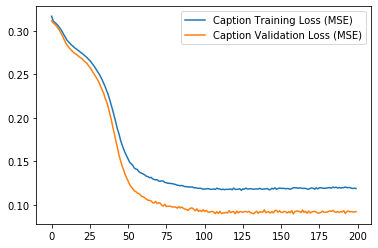

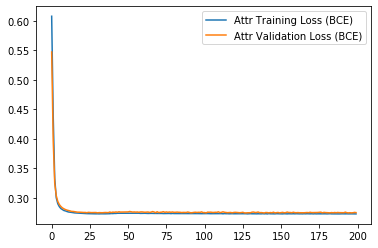

In [16]:
plot_save_dir = 'bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-balanced'

# Val loss is lower because dropout isn't active during testing
# https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss

plt.plot(history.history['caption_out_loss'], label="Caption Training Loss (MSE)")
plt.plot(history.history['val_caption_out_loss'], label="Caption Validation Loss (MSE)")
plt.legend()
plt.savefig('./results/plots/'+plot_save_dir+'/autoencoder_caption_loss.png')
plt.show()

plt.plot(history.history['attr_out_loss'], label="Attr Training Loss (BCE)")
plt.plot(history.history['val_attr_out_loss'], label="Attr Validation Loss (BCE)")
plt.legend()
plt.savefig('./results/plots/'+plot_save_dir+'/autoencoder_attr_loss.png')
plt.show()


In [ ]:
# autoencoder.save_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34/autoencoder-conv1d-200.h5')

In [19]:
# Just some testing
idx=33
print(a_test[idx])
output = autoencoder.predict(c_test[idx].reshape(1, -1))
print(np.round(output[1][0]))
print(output[1][0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0.07249631 0.2940944  0.0267831  0.01537494 0.0247544  0.35318598
 0.1796633  0.0550007  0.03178422 0.01538806 0.05027523 0.42295325
 0.32761505 0.04839002 0.21588916 0.05055666 0.5904929  0.02142788
 0.2076882  0.29177445 0.03280817 0.0235082  0.02062405 0.07023036
 0.01338741 0.08096099 0.06181133 0.06326099 0.07672581 0.04063533
 0.06498345 0.03066378 0.04572986 0.5677986 ]


In [14]:
# Extract encoder from autoencoder
autoencoder.load_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34/autoencoder-conv1d-200.h5')
encoder = Model(autoencoder.input, autoencoder.get_layer('attr_out').output)
# for layer in encoder.layers:
#     layer.trainable = True
encoder.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
reshape (Reshape)            (None, 1024, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 512, 16)           64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 512, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 32)           1568      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 32)           0   

In [15]:
def make_generator_model(shape):
    
    noise_in = Input(shape=shape)
    captions_in = Input(shape=(1024,))
    
    c = encoder(captions_in)
    
    input_layer = concatenate([noise_in, c])
    
    x = Dense(16*16*64*2)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 128))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model([noise_in, captions_in], [x, c])

In [16]:
generator = make_generator_model((300,))
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 34)           286402      input_3[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 334)          0           input_2[0][0]                    
                                                                 model_1[1][0]              

(1024,)


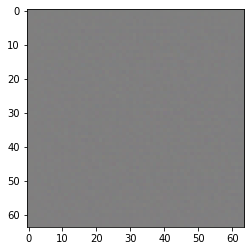

In [29]:
generator = make_generator_model((300,))

noise = np.random.normal(0, 1, 300)
label = train_captions[0]
print(label.shape)

generated_image = generator.predict( [np.array([noise]), np.array([label])] )[0][0]
plt.imshow(unnormalize_img(generated_image), )

In [30]:
def make_valid_discriminator_model():
    input_layer = Input((64, 64, 3))
#     x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', name='valid')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(64)(x) 
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    valid = Dense(1, activation='sigmoid')(x)
    
    return Model(input_layer, valid)

In [31]:
discriminator_valid = make_valid_discriminator_model()
discriminator_valid.summary()
valid = discriminator_valid.predict(np.array([generated_image]))


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
valid (Conv2D)               (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 32, 32, 64)        0   

In [32]:
def make_attr_discriminator_model():
    input_layer = Input((64, 64, 3))
    
#     x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', name='attr')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)


#     x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
#     x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
#     x = Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
#     x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
#     x = LeakyReLU()(x)
#     x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = Dense(128)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(48)(x)
    x = Dense(64)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    attr = Dense(34, activation='sigmoid')(x)
    
    return Model(input_layer, attr)

In [33]:
discriminator_attr = make_attr_discriminator_model()
discriminator_attr.summary()
attrs = discriminator_attr.predict(np.array([generated_image]))

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
attr (Conv2D)                (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 32, 32, 64)        0   

In [34]:
cross_entropy = BinaryCrossentropy(from_logits=False)

@tf.function
def discriminator_valid_loss(real_output, fake_output, flip):
    
    if flip:
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.9, maxval=1.0)
        real_labels = tf.random.uniform(real_output.shape, minval=0.0, maxval=0.1)
    else:
        real_labels = tf.random.uniform(real_output.shape, minval=0.9, maxval=1.0)
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.0, maxval=0.1)

        
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

In [35]:
# mse = MeanSquaredError()

@tf.function
def discriminator_attribute_loss_real(real_output, real_attributes):
    return cross_entropy(real_output, real_attributes)

@tf.function
def discriminator_attribute_loss_fake(fake_output, fake_attributes):
    return cross_entropy(fake_output, fake_attributes)

In [36]:
@tf.function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def generator_attr_loss(fake_attr_output, sampled_attrs):
    return cross_entropy(fake_attr_output, sampled_attrs)

@tf.function
def generator_caption_loss(fake_caption_output, sampled_captions):
    return cross_entropy(fake_caption_output, sampled_captions)

In [37]:
@tf.function
def train_step(images, attrs, captions, sampled_attrs, sampled_captions, flip, warmup):
    noise = tf.random.truncated_normal([32, 300], dtype=tf.dtypes.float64)
    
#     sampled_attrs = tf.cast(tf.random.uniform([32, 312], minval=0, maxval=2, dtype='int32'), 'float32') # Need to make this smarter. Only one 1 per attr.
#     attrs = tf.reshape(attrs, (attrs.shape[0], 1))
    
    gen_losses = []
    gen_valid_losses = []
    gen_attr_losses = []
    gen_caption_losses = []
    disc_losses = []
    disc_real_losses = []
    disc_fake_losses = []
    disc_attr_real_losses = []
    disc_attr_fake_losses = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape_valid, tf.GradientTape() as disc_tape_attr:
        gen_tape.watch(generator.trainable_variables)
        disc_tape_valid.watch(discriminator_valid.trainable_variables)
        disc_tape_attr.watch(discriminator_attr.trainable_variables)
        
        generated_images, generated_attrs = generator([noise, sampled_captions], training=True)
        
        real_output = discriminator_valid(images, training=True)
        fake_output = discriminator_valid(generated_images, training=True)
        
        real_attr_output = discriminator_attr(images, training=True)
        fake_attr_output = discriminator_attr(generated_images, training=True)
        
        gen_valid_loss = generator_loss(fake_output)
        gen_attr_loss = generator_attr_loss(fake_attr_output, sampled_attrs)
        gen_caption_loss = generator_caption_loss(generated_attrs, sampled_attrs)
        gen_loss = ((2.0 - warmup) * gen_valid_loss + (warmup * (gen_attr_loss + gen_caption_loss)))
        
        disc_valid_loss, disc_real_loss, disc_fake_loss = discriminator_valid_loss(real_output, fake_output, flip)
        disc_attr_real_loss = discriminator_attribute_loss_real(real_attr_output, attrs)
        disc_attr_fake_loss = discriminator_attribute_loss_fake(fake_attr_output, sampled_attrs)
        disc_attr_loss = ((2.0 - warmup) * disc_attr_real_loss + warmup * disc_attr_fake_loss)
#         disc_loss += ((2.0 - warmup) * disc_attr_real_loss + warmup * disc_attr_fake_loss)
        
        
        gen_losses.append(K.mean(gen_loss))
        gen_valid_losses.append(K.mean(gen_valid_loss))
        gen_attr_losses.append(K.mean(gen_attr_loss))
        gen_caption_losses.append(K.mean(gen_caption_loss))
        disc_losses.append(K.mean(disc_valid_loss))
        disc_real_losses.append(K.mean(disc_real_loss))
        disc_fake_losses.append(K.mean(disc_fake_loss))
        disc_attr_real_losses.append(K.mean(disc_attr_real_loss))
        disc_attr_fake_losses.append(K.mean(disc_attr_fake_loss))
    
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator_valid = disc_tape_valid.gradient(disc_valid_loss, discriminator_valid.trainable_variables)
    
    gradients_of_discriminator_attr = disc_tape_attr.gradient(disc_attr_loss, discriminator_attr.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    discriminator_valid_optimizer.apply_gradients(zip(gradients_of_discriminator_valid, discriminator_valid.trainable_variables))
    
    discriminator_attr_optimizer.apply_gradients(zip(gradients_of_discriminator_attr, discriminator_attr.trainable_variables))

    return (gen_losses, gen_valid_losses, gen_attr_losses, gen_caption_losses, disc_losses, disc_real_losses, disc_fake_losses, disc_attr_real_losses, disc_attr_fake_losses)

In [38]:
def train(train_imgs, train_attrs, train_captions, epochs, warmup):
    gen_loss_all = []
    gen_valid_loss_all = []
    gen_attr_loss_all = []
    gen_caption_loss_all = []
    disc_loss_all = []
    disc_loss_real_all = []
    disc_loss_fake_all = []
    disc_attr_loss_real_all = []
    disc_attr_loss_fake_all = []
    warmup_step = 1./2000.
    
    num_samples = len(train_imgs)
    batch_counter = 0
    
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = [1, 0]
        gen_valid_loss_epoch = [1, 0]
        gen_attr_loss_epoch = [1, 0]
        gen_caption_loss_epoch = [1, 0]
        disc_loss_epoch = [1, 0]
        disc_loss_real_epoch = [1, 0]
        disc_loss_fake_epoch = [1, 0]
        disc_attr_loss_real_epoch = [1, 0]
        disc_attr_loss_fake_epoch = [1, 0]
        
        seed = np.random.randint(0, 10000)
        np.random.seed(seed)
        np.random.shuffle(train_imgs)
        np.random.seed(seed)
        np.random.shuffle(train_attrs)
        np.random.seed(seed)
        np.random.shuffle(train_captions)
        
        all_indices = np.arange(len(train_attrs))
        np.random.shuffle(all_indices)
        
        for idx, i in enumerate(range(0, num_samples - 32, 32)):
            
            sampled_indices = all_indices[i:(i+32)]
            
            gen_loss_batch, gen_valid_loss_batch, gen_attr_loss_batch, gen_caption_loss_batch, disc_loss_batch, disc_loss_real_batch, disc_loss_fake_batch, disc_attr_loss_real_batch, disc_attr_loss_fake_batch = train_step(train_imgs[i:(i+32)], train_attrs[i:(i+32)], train_captions[i:(i+32)], train_attrs[sampled_indices], train_captions[sampled_indices], batch_counter % 20 == 0, tf.constant(warmup, dtype='float32'))

            gen_loss_epoch[0] += 1
            gen_valid_loss_epoch[0] += 1
            gen_attr_loss_epoch[0] += 1
            gen_caption_loss_epoch[0] += 1
            disc_loss_epoch[0] += 1
            disc_loss_real_epoch[0] += 1
            disc_loss_fake_epoch[0] += 1
            disc_attr_loss_real_epoch[0] += 1
            disc_attr_loss_fake_epoch[0] += 1
            gen_loss_epoch[1] += np.mean(gen_loss_batch)
            gen_valid_loss_epoch[1] += np.mean(gen_valid_loss_batch)
            gen_attr_loss_epoch[1] += np.mean(gen_attr_loss_batch)
            gen_caption_loss_epoch[1] += np.mean(gen_caption_loss_batch)
            disc_loss_epoch[1] += np.mean(disc_loss_batch)
            disc_loss_real_epoch[1] += np.mean(disc_loss_real_batch)
            disc_loss_fake_epoch[1] += np.mean(disc_loss_fake_batch)
            disc_attr_loss_real_epoch[1] += np.mean(disc_attr_loss_real_batch)
            disc_attr_loss_fake_epoch[1] += np.mean(disc_attr_loss_fake_batch)
            
            batch_counter += 1
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(f'Gen loss: {gen_loss_epoch[1]/gen_loss_epoch[0]}, Gen valid loss: {gen_valid_loss_epoch[1]/gen_valid_loss_epoch[0]}, Gen attr loss: {gen_attr_loss_epoch[1]/gen_attr_loss_epoch[0]}, Gen caption loss: {gen_caption_loss_epoch[1]/gen_caption_loss_epoch[0]}, Disc valid loss: {disc_loss_epoch[1]/disc_loss_epoch[0]}, Disc valid real loss: {disc_loss_real_epoch[1]/disc_loss_real_epoch[0]}, Disc valid fake loss: {disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0]}, Disc attr loss: {(disc_attr_loss_real_epoch[1] + disc_attr_loss_fake_epoch[1])/(disc_attr_loss_real_epoch[0])}, Disc attr real loss: {disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0]}, Disc attr fake loss: {disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0]}')
        
        gen_loss_all.append(gen_loss_epoch[1]/gen_loss_epoch[0])
        gen_valid_loss_all.append(gen_valid_loss_epoch[1]/gen_valid_loss_epoch[0])
        gen_attr_loss_all.append(gen_attr_loss_epoch[1]/gen_attr_loss_epoch[0])
        gen_caption_loss_all.append(gen_caption_loss_epoch[1]/gen_caption_loss_epoch[0])
        disc_loss_all.append(disc_loss_epoch[1]/disc_loss_epoch[0])
        disc_loss_real_all.append(disc_loss_real_epoch[1]/disc_loss_real_epoch[0])
        disc_loss_fake_all.append(disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0])
        disc_attr_loss_real_all.append(disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0])
        disc_attr_loss_fake_all.append(disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0])
        
        if warmup < 1:
            warmup += warmup_step
    
    return (gen_loss_all, gen_valid_loss_all, gen_attr_loss_all, gen_caption_loss_all, disc_loss_all, disc_loss_real_all, disc_loss_fake_all, disc_attr_loss_real_all, disc_attr_loss_fake_all, warmup)
    


In [39]:
def long_train(starting_checkpoint=0, num_checkpoints=0, checkpoint_interval=0, g_hist=None, g_valid_hist=None, g_attr_hist=None, g_caption_hist=None, d_hist=None, d_real_hist=None, d_fake_hist=None, d_attr_real_hist=None, d_attr_fake_hist=None, noise=None, caption=None, save_files=False, warmup=0.):

    for i in range(starting_checkpoint, starting_checkpoint + num_checkpoints):
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('')
        print(f'Starting checkpoint {i}')
        print('')
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        gen_temp, gen_valid_temp, gen_attr_temp, gen_caption_temp, disc_temp, disc_real_temp, disc_fake_temp, disc_attr_real_temp, disc_attr_fake_temp, warmup = train(train_imgs, train_attrs, train_captions, checkpoint_interval, warmup)
        
        g_hist += gen_temp
        g_valid_hist += gen_valid_temp
        g_attr_hist += gen_attr_temp
        g_caption_hist += gen_caption_temp
        d_hist += disc_temp
        d_real_hist += disc_real_temp
        d_fake_hist += disc_fake_temp
        d_attr_real_hist += disc_attr_real_temp
        d_attr_fake_hist += disc_attr_fake_temp
        generated_image = generator.predict( [np.array([noise]), np.array([caption])])[0][0]
        plt.imshow(unnormalize_img(generated_image))
        if save_files:
            plt.savefig('./results/prog-imgs/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-balanced/' + str((i+1)*checkpoint_interval) + '.png')
        plt.show()
        if save_files:
            generator.save_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-balanced/gen_weights_attributes_split_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator_valid.save_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-balanced/disc_weights_attributes_split_valid_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator_attr.save_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-balanced/disc_weights_attributes_split_attr_' + str((i+1)*checkpoint_interval) + '.h5')
    
    return starting_checkpoint + num_checkpoints, totalepochs, warmup

In [40]:
discriminator_valid = make_valid_discriminator_model()
discriminator_attr = make_attr_discriminator_model()
generator = make_generator_model((300,))
generator_optimizer = Adam(1e-4, beta_1=0.5)
discriminator_valid_optimizer = Adam(1e-4, beta_1=0.5)
discriminator_attr_optimizer = Adam(1e-5, beta_1=0.5)

In [41]:
# To get passed into training function and get modified
# Run cell when starting from scratch
gen_loss_hist = []
gen_valid_loss_hist = []
gen_attr_loss_hist = []
gen_caption_loss_hist = []
disc_loss_hist = []
disc_loss_real_hist = []
disc_loss_fake_hist = []
disc_attr_loss_real_hist = []
disc_attr_loss_fake_hist = []
noise300 = np.random.normal(0, 1, 300)
caption = train_captions[5000]
next_starting_checkpoint = 0
totalepochs = 0
warmup = 1.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 40

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 37.16783046722412 sec
Gen loss: 4.40957394848025, Gen valid loss: 1.2742530449942198, Gen attr loss: 1.5976330093575042, Gen caption loss: 1.5376879054356396, Disc valid loss: 1.0992274046913395, Disc valid real loss: 0.5555857115483219, Disc valid fake loss: 0.5436416934660779, Disc attr loss: 2.8360148451838714, Disc attr real loss: 1.2383818358263672, Disc attr fake loss: 1.5976330093575042
Time for epoch 2 is 37.284485816955566 sec
Gen loss: 4.3895096113365195, Gen valid loss: 1.2680055169555229, Gen attr loss: 1.589406473849847, Gen caption loss: 1.532097617139015, Disc valid loss: 1.0973254212842078, Disc valid real loss: 0.5547176431511153, Disc valid fake loss: 0.542607776113965, Disc attr loss: 2.827641682573127, Disc attr real loss: 1.2382352087232802, Disc attr fake loss: 1.589406473849847
Time for epoch 3 is 37.661925077438354 sec
Gen loss

Time for epoch 21 is 39.51524043083191 sec
Gen loss: 4.389592079612298, Gen valid loss: 1.2609347773761284, Gen attr loss: 1.5935389853428372, Gen caption loss: 1.535118325615963, Disc valid loss: 1.107361910304403, Disc valid real loss: 0.5612563501367078, Disc valid fake loss: 0.5461055614599367, Disc attr loss: 2.8310037392587843, Disc attr real loss: 1.237464753915947, Disc attr fake loss: 1.5935389853428372
Time for epoch 22 is 39.31409525871277 sec
Gen loss: 4.384793005015469, Gen valid loss: 1.2603990296684306, Gen attr loss: 1.5945566107587117, Gen caption loss: 1.5298373663651588, Disc valid loss: 1.100521877206115, Disc valid real loss: 0.5574180261714026, Disc valid fake loss: 0.5431038523269539, Disc attr loss: 2.832032411402157, Disc attr real loss: 1.2374758006434454, Disc attr fake loss: 1.5945566107587117
Time for epoch 23 is 39.429651975631714 sec
Gen loss: 4.385029248105801, Gen valid loss: 1.2613837609123084, Gen attr loss: 1.592598439555181, Gen caption loss: 1.5310

Time for epoch 41 is 39.537402868270874 sec
Gen loss: 4.381010153106234, Gen valid loss: 1.2624822559395457, Gen attr loss: 1.5876084104139954, Gen caption loss: 1.530919487883405, Disc valid loss: 1.1031591591796255, Disc valid real loss: 0.5595789770608349, Disc valid fake loss: 0.5435801852686295, Disc attr loss: 2.824812483173722, Disc attr real loss: 1.2372040727597264, Disc attr fake loss: 1.5876084104139954
Time for epoch 42 is 39.5045268535614 sec
Gen loss: 4.3839360129865526, Gen valid loss: 1.2655349997324026, Gen attr loss: 1.5905954068915307, Gen caption loss: 1.527805622031049, Disc valid loss: 1.1029635469118755, Disc valid real loss: 0.559426366071391, Disc valid fake loss: 0.5435371847979744, Disc attr loss: 2.8279246007846948, Disc attr real loss: 1.2373291938931639, Disc attr fake loss: 1.5905954068915307
Time for epoch 43 is 39.53549313545227 sec
Gen loss: 4.401409708064423, Gen valid loss: 1.2787874389470109, Gen attr loss: 1.5930911325180757, Gen caption loss: 1.52

Time for epoch 61 is 39.49463438987732 sec
Gen loss: 4.383283097569535, Gen valid loss: 1.2635368958398256, Gen attr loss: 1.5896238702422558, Gen caption loss: 1.5301223431176287, Disc valid loss: 1.0991067740975358, Disc valid real loss: 0.5590713360929876, Disc valid fake loss: 0.5400354385699037, Disc attr loss: 2.826553911859104, Disc attr real loss: 1.2369300416168483, Disc attr fake loss: 1.5896238702422558
Time for epoch 62 is 39.5013062953949 sec
Gen loss: 4.397282635939477, Gen valid loss: 1.2783058881759644, Gen attr loss: 1.589423312081231, Gen caption loss: 1.5295534456971538, Disc valid loss: 1.0904360447472674, Disc valid real loss: 0.5551668112355519, Disc valid fake loss: 0.5352692343193665, Disc attr loss: 2.8258926417769454, Disc attr real loss: 1.2364693296957145, Disc attr fake loss: 1.589423312081231
Time for epoch 63 is 39.732686042785645 sec
Gen loss: 4.409360316387683, Gen valid loss: 1.2840762511501467, Gen attr loss: 1.594061272254158, Gen caption loss: 1.531

Time for epoch 81 is 39.51631426811218 sec
Gen loss: 4.388237002742323, Gen valid loss: 1.2705339408179286, Gen attr loss: 1.5896301544132594, Gen caption loss: 1.5280729112263294, Disc valid loss: 1.09817801016133, Disc valid real loss: 0.5562890852854504, Disc valid fake loss: 0.5418889231798125, Disc attr loss: 2.8241548904881566, Disc attr real loss: 1.2345247360748974, Disc attr fake loss: 1.5896301544132594
Time for epoch 82 is 39.53146147727966 sec
Gen loss: 4.408698275160337, Gen valid loss: 1.2839905743999533, Gen attr loss: 1.5932203298661767, Gen caption loss: 1.531487366694422, Disc valid loss: 1.0893695990890668, Disc valid real loss: 0.5499881148984439, Disc valid fake loss: 0.5393814836252673, Disc attr loss: 2.827801893235545, Disc attr real loss: 1.2345815633693684, Disc attr fake loss: 1.5932203298661767
Time for epoch 83 is 39.51772665977478 sec
Gen loss: 4.378367199807309, Gen valid loss: 1.2592229148559777, Gen attr loss: 1.5895899382387073, Gen caption loss: 1.529

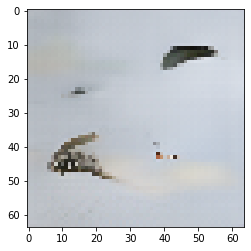

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 41

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.406259059906006 sec
Gen loss: 4.374934679770535, Gen valid loss: 1.2634178073748663, Gen attr loss: 1.588774784147578, Gen caption loss: 1.522742091478694, Disc valid loss: 1.103220342136011, Disc valid real loss: 0.563428274095866, Disc valid fake loss: 0.5397920698977421, Disc attr loss: 2.8205094550683247, Disc attr real loss: 1.2317346709207468, Disc attr fake loss: 1.588774784147578
Time for epoch 2 is 39.436309814453125 sec
Gen loss: 4.387740305768765, Gen valid loss: 1.268091731278231, Gen attr loss: 1.5909957827591314, Gen caption loss: 1.5286527836548927, Disc valid loss: 1.1007511832203645, Disc valid real loss: 0.5640143659218217, Disc valid fake loss: 0.5367368193984354, Disc attr loss: 2.8270035566999336, Disc attr real loss: 1.2360077739408022, Disc attr fake loss: 1.5909957827591314
Time for epoch 3 is 39.575520515441895 sec
Gen loss

Time for epoch 21 is 39.40047287940979 sec
Gen loss: 4.382927952743158, Gen valid loss: 1.2628396738189345, Gen attr loss: 1.5901891581088223, Gen caption loss: 1.5298991161310254, Disc valid loss: 1.1030403398239839, Disc valid real loss: 0.561507514256449, Disc valid fake loss: 0.541532824840649, Disc attr loss: 2.8255141505057897, Disc attr real loss: 1.2353249923969671, Disc attr fake loss: 1.5901891581088223
Time for epoch 22 is 39.43947649002075 sec
Gen loss: 4.397525767969891, Gen valid loss: 1.273988322029269, Gen attr loss: 1.5930362519856067, Gen caption loss: 1.5305011757021028, Disc valid loss: 1.0978867629679239, Disc valid real loss: 0.555440253116251, Disc valid fake loss: 0.5424465130822769, Disc attr loss: 2.826690977666436, Disc attr real loss: 1.2336547256808295, Disc attr fake loss: 1.5930362519856067
Time for epoch 23 is 39.39365363121033 sec
Gen loss: 4.372626533353232, Gen valid loss: 1.256143309236542, Gen attr loss: 1.5873676825991168, Gen caption loss: 1.52911

Time for epoch 41 is 39.38341522216797 sec
Gen loss: 4.40060040944314, Gen valid loss: 1.2799043747467724, Gen attr loss: 1.589044073732888, Gen caption loss: 1.5316519630633718, Disc valid loss: 1.097975827167997, Disc valid real loss: 0.5615705782320441, Disc valid fake loss: 0.5364052528934427, Disc attr loss: 2.8256149543979303, Disc attr real loss: 1.2365708806650426, Disc attr fake loss: 1.589044073732888
Time for epoch 42 is 39.43827271461487 sec
Gen loss: 4.376803596491413, Gen valid loss: 1.2593259855014522, Gen attr loss: 1.5889422696457323, Gen caption loss: 1.5285353366598526, Disc valid loss: 1.1033896270806227, Disc valid real loss: 0.5590711085776973, Disc valid fake loss: 0.5443185179375698, Disc attr loss: 2.8236932699596333, Disc attr real loss: 1.234751000313901, Disc attr fake loss: 1.5889422696457323
Time for epoch 43 is 39.422128438949585 sec
Gen loss: 4.386018648380187, Gen valid loss: 1.2683403146299244, Gen attr loss: 1.5899111481539925, Gen caption loss: 1.527

Time for epoch 61 is 39.36473631858826 sec
Gen loss: 4.398646253234325, Gen valid loss: 1.2757887061695419, Gen attr loss: 1.5914870584560281, Gen caption loss: 1.5313705012081116, Disc valid loss: 1.0934955363028094, Disc valid real loss: 0.5564510595346208, Disc valid fake loss: 0.5370444784642558, Disc attr loss: 2.8285378954274867, Disc attr real loss: 1.2370508369714588, Disc attr fake loss: 1.5914870584560281
Time for epoch 62 is 39.31539750099182 sec
Gen loss: 4.376950307913266, Gen valid loss: 1.2565021631194324, Gen attr loss: 1.5929266938026034, Gen caption loss: 1.527521460683042, Disc valid loss: 1.1088479392250703, Disc valid real loss: 0.5669953424109999, Disc valid fake loss: 0.5418525951987683, Disc attr loss: 2.827621449946065, Disc attr real loss: 1.2346947561434614, Disc attr fake loss: 1.5929266938026034
Time for epoch 63 is 39.31849479675293 sec
Gen loss: 4.394478797912598, Gen valid loss: 1.2673197419339726, Gen attr loss: 1.5959680054568985, Gen caption loss: 1.5

Time for epoch 81 is 39.35108041763306 sec
Gen loss: 4.399950690385772, Gen valid loss: 1.2716685775818863, Gen attr loss: 1.5945333901459608, Gen caption loss: 1.53374873493422, Disc valid loss: 1.0997388829706807, Disc valid real loss: 0.5568486815545617, Disc valid fake loss: 0.5428902001238773, Disc attr loss: 2.8287920165191176, Disc attr real loss: 1.2342586263731565, Disc attr fake loss: 1.5945333901459608
Time for epoch 82 is 39.30616092681885 sec
Gen loss: 4.397516190521116, Gen valid loss: 1.2732655410844136, Gen attr loss: 1.5912854093200146, Gen caption loss: 1.5329652375322047, Disc valid loss: 1.0969727475468705, Disc valid real loss: 0.5559905235198778, Disc valid fake loss: 0.5409822271768316, Disc attr loss: 2.8231542701643657, Disc attr real loss: 1.231868860844351, Disc attr fake loss: 1.5912854093200146
Time for epoch 83 is 39.22150540351868 sec
Gen loss: 4.379689029238734, Gen valid loss: 1.2626803859785642, Gen attr loss: 1.5900272066354106, Gen caption loss: 1.52

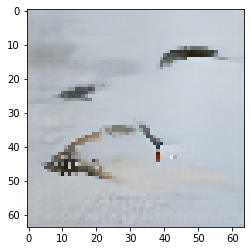

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 42

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.334277629852295 sec
Gen loss: 4.377217884632307, Gen valid loss: 1.2609725224616404, Gen attr loss: 1.587129810638221, Gen caption loss: 1.5291155405483918, Disc valid loss: 1.1064614409676736, Disc valid real loss: 0.5640107877855378, Disc valid fake loss: 0.5424506578665116, Disc attr loss: 2.823599476316757, Disc attr real loss: 1.2364696656785361, Disc attr fake loss: 1.587129810638221
Time for epoch 2 is 39.204288721084595 sec
Gen loss: 4.383881053304284, Gen valid loss: 1.265512244003575, Gen attr loss: 1.5886881467772693, Gen caption loss: 1.5296806484703127, Disc valid loss: 1.0956602346929432, Disc valid real loss: 0.5549374838993155, Disc valid fake loss: 0.5407227523281646, Disc attr loss: 2.820426875821297, Disc attr real loss: 1.2317387290440278, Disc attr fake loss: 1.5886881467772693
Time for epoch 3 is 39.34689140319824 sec
Gen loss

Time for epoch 21 is 39.258456230163574 sec
Gen loss: 4.368682257851288, Gen valid loss: 1.252236386624778, Gen attr loss: 1.5884086271611655, Gen caption loss: 1.5280372359888341, Disc valid loss: 1.1057235710019988, Disc valid real loss: 0.5578176636036819, Disc valid fake loss: 0.5479059049753638, Disc attr loss: 2.823160412027261, Disc attr real loss: 1.2347517848660952, Disc attr fake loss: 1.5884086271611655
Time for epoch 22 is 39.3385534286499 sec
Gen loss: 4.398772411553194, Gen valid loss: 1.275455474368925, Gen attr loss: 1.5909068988267645, Gen caption loss: 1.5324100475647262, Disc valid loss: 1.0922183785335158, Disc valid real loss: 0.554814026203905, Disc valid fake loss: 0.5374043518450202, Disc attr loss: 2.8256150484085083, Disc attr real loss: 1.2347081495817438, Disc attr fake loss: 1.5909068988267645
Time for epoch 23 is 39.26950693130493 sec
Gen loss: 4.388095467394283, Gen valid loss: 1.2705481939199494, Gen attr loss: 1.588852356442914, Gen caption loss: 1.5286

Time for epoch 41 is 39.279940366744995 sec
Gen loss: 4.388897287813306, Gen valid loss: 1.2674735799068357, Gen attr loss: 1.5921171209030358, Gen caption loss: 1.5293065907186285, Disc valid loss: 1.107482115427653, Disc valid real loss: 0.5603361052226244, Disc valid fake loss: 0.5471460140817533, Disc attr loss: 2.823921419417632, Disc attr real loss: 1.2318042985145963, Disc attr fake loss: 1.5921171209030358
Time for epoch 42 is 39.60857152938843 sec
Gen loss: 4.370759705540934, Gen valid loss: 1.2482116366143472, Gen attr loss: 1.5902664089590552, Gen caption loss: 1.5322816652980278, Disc valid loss: 1.1003483151032674, Disc valid real loss: 0.5594844197839256, Disc valid fake loss: 0.5408638979038249, Disc attr loss: 2.8223071185553947, Disc attr real loss: 1.2320407095963393, Disc attr fake loss: 1.5902664089590552
Time for epoch 43 is 39.32779383659363 sec
Gen loss: 4.39761576161475, Gen valid loss: 1.262628208977097, Gen attr loss: 1.601417935960661, Gen caption loss: 1.533

Time for epoch 61 is 39.54197907447815 sec
Gen loss: 4.372310257862577, Gen valid loss: 1.251651399826939, Gen attr loss: 1.5919090832475078, Gen caption loss: 1.5287497731728283, Disc valid loss: 1.104351718897419, Disc valid real loss: 0.5586748746675527, Disc valid fake loss: 0.545676843260685, Disc attr loss: 2.8239749925246405, Disc attr real loss: 1.2320659092771329, Disc attr fake loss: 1.5919090832475078
Time for epoch 62 is 39.570268630981445 sec
Gen loss: 4.399864957907659, Gen valid loss: 1.2780078817512284, Gen attr loss: 1.591095442694377, Gen caption loss: 1.5307616396002006, Disc valid loss: 1.0901120271139997, Disc valid real loss: 0.5529615575382056, Disc valid fake loss: 0.5371504682835525, Disc attr loss: 2.8256871740669416, Disc attr real loss: 1.2345917313725645, Disc attr fake loss: 1.591095442694377
Time for epoch 63 is 39.51914095878601 sec
Gen loss: 4.391530272114244, Gen valid loss: 1.273516807452773, Gen attr loss: 1.5882669580661184, Gen caption loss: 1.5297

Time for epoch 81 is 39.531888484954834 sec
Gen loss: 4.395597585817662, Gen valid loss: 1.272078297164059, Gen attr loss: 1.5880451819437953, Gen caption loss: 1.5354741026715535, Disc valid loss: 1.0987403543014838, Disc valid real loss: 0.5529901611449596, Disc valid fake loss: 0.5457501929949938, Disc attr loss: 2.819116240432915, Disc attr real loss: 1.2310710584891198, Disc attr fake loss: 1.5880451819437953
Time for epoch 82 is 39.7698540687561 sec
Gen loss: 4.365522210190936, Gen valid loss: 1.2526776622627487, Gen attr loss: 1.5876890269075306, Gen caption loss: 1.525155530712469, Disc valid loss: 1.1049998845188276, Disc valid real loss: 0.5599106704478019, Disc valid fake loss: 0.5450892135864351, Disc attr loss: 2.8203510793890088, Disc attr real loss: 1.2326620524814782, Disc attr fake loss: 1.5876890269075306
Time for epoch 83 is 39.61097478866577 sec
Gen loss: 4.3972110890437595, Gen valid loss: 1.283186096970628, Gen attr loss: 1.5840102598919132, Gen caption loss: 1.53

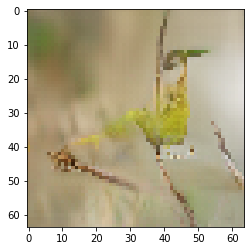

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 43

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.54909610748291 sec
Gen loss: 4.402870451531759, Gen valid loss: 1.2838696158998382, Gen attr loss: 1.5887532363416057, Gen caption loss: 1.530247591052275, Disc valid loss: 1.0946323503323687, Disc valid real loss: 0.5566151411068149, Disc valid fake loss: 0.5380172097909095, Disc attr loss: 2.8215520052405876, Disc attr real loss: 1.232798768898982, Disc attr fake loss: 1.5887532363416057
Time for epoch 2 is 39.4505398273468 sec
Gen loss: 4.381923314355577, Gen valid loss: 1.2656115705404825, Gen attr loss: 1.5868344219719492, Gen caption loss: 1.5294773216816144, Disc valid loss: 1.09621202768026, Disc valid real loss: 0.5586665696729489, Disc valid fake loss: 0.5375454560689487, Disc attr loss: 2.8174565686442987, Disc attr real loss: 1.2306221466723497, Disc attr fake loss: 1.5868344219719492
Time for epoch 3 is 39.51507639884949 sec
Gen loss: 

Time for epoch 21 is 39.57428050041199 sec
Gen loss: 4.3896990210060185, Gen valid loss: 1.275969307920151, Gen attr loss: 1.587379756012583, Gen caption loss: 1.5263499699957002, Disc valid loss: 1.0982022833048812, Disc valid real loss: 0.5580039970112364, Disc valid fake loss: 0.540198287989712, Disc attr loss: 2.818044994904743, Disc attr real loss: 1.2306652388921597, Disc attr fake loss: 1.587379756012583
Time for epoch 22 is 39.56763577461243 sec
Gen loss: 4.386801576226707, Gen valid loss: 1.2746731469301673, Gen attr loss: 1.5865042668371019, Gen caption loss: 1.5256241685975858, Disc valid loss: 1.0928528037497667, Disc valid real loss: 0.5592173888754393, Disc valid fake loss: 0.5336354157627436, Disc attr loss: 2.8178184205277503, Disc attr real loss: 1.2313141536906482, Disc attr fake loss: 1.5865042668371019
Time for epoch 23 is 39.60080170631409 sec
Gen loss: 4.37938978032368, Gen valid loss: 1.2616482910101976, Gen attr loss: 1.5885498736932027, Gen caption loss: 1.5291

Time for epoch 41 is 39.57843494415283 sec
Gen loss: 4.394916805794568, Gen valid loss: 1.2659060610988275, Gen attr loss: 1.5939737891117085, Gen caption loss: 1.5350369618837103, Disc valid loss: 1.0986190409195133, Disc valid real loss: 0.5585965759708953, Disc valid fake loss: 0.5400224640602018, Disc attr loss: 2.8240880297451483, Disc attr real loss: 1.23011424063344, Disc attr fake loss: 1.5939737891117085
Time for epoch 42 is 39.88591408729553 sec
Gen loss: 4.393262246113806, Gen valid loss: 1.2711780762607812, Gen attr loss: 1.5888744166226891, Gen caption loss: 1.533209752261154, Disc valid loss: 1.0961919120010646, Disc valid real loss: 0.5556123137958651, Disc valid fake loss: 0.5405795973975484, Disc attr loss: 2.8175241499735413, Disc attr real loss: 1.228649733350852, Disc attr fake loss: 1.5888744166226891
Time for epoch 43 is 39.58827185630798 sec
Gen loss: 4.383056169602929, Gen valid loss: 1.2616547808091492, Gen attr loss: 1.5913345561764105, Gen caption loss: 1.530

Time for epoch 61 is 39.60937023162842 sec
Gen loss: 4.388894925595622, Gen valid loss: 1.266954488709044, Gen attr loss: 1.5898916165680097, Gen caption loss: 1.5320488098191052, Disc valid loss: 1.1005108122257037, Disc valid real loss: 0.5562604740060119, Disc valid fake loss: 0.5442503397542287, Disc attr loss: 2.8191202988792563, Disc attr real loss: 1.2292286823112466, Disc attr fake loss: 1.5898916165680097
Time for epoch 62 is 39.64505124092102 sec
Gen loss: 4.380562998091948, Gen valid loss: 1.2632503953729541, Gen attr loss: 1.5889995660239118, Gen caption loss: 1.5283130287801023, Disc valid loss: 1.0984145293067786, Disc valid real loss: 0.5560831209508384, Disc valid fake loss: 0.542331407305994, Disc attr loss: 2.818061384405224, Disc attr real loss: 1.229061818381312, Disc attr fake loss: 1.5889995660239118
Time for epoch 63 is 39.59521484375 sec
Gen loss: 4.399035981030968, Gen valid loss: 1.2718014789790641, Gen attr loss: 1.5929776669194704, Gen caption loss: 1.534256

Time for epoch 81 is 39.59797716140747 sec
Gen loss: 4.386050392941731, Gen valid loss: 1.2652684794208868, Gen attr loss: 1.5904641261268762, Gen caption loss: 1.5303177888477397, Disc valid loss: 1.1024102770539157, Disc valid real loss: 0.5575349758149486, Disc valid fake loss: 0.5448753020466182, Disc attr loss: 2.821043183325429, Disc attr real loss: 1.2305790571985529, Disc attr fake loss: 1.5904641261268762
Time for epoch 82 is 39.77822422981262 sec
Gen loss: 4.385045549087732, Gen valid loss: 1.2647951036933962, Gen attr loss: 1.590065934147615, Gen caption loss: 1.5301845151234448, Disc valid loss: 1.1030285809098221, Disc valid real loss: 0.5598640988674267, Disc valid fake loss: 0.5431644826885161, Disc attr loss: 2.8198263226808895, Disc attr real loss: 1.2297603885332744, Disc attr fake loss: 1.590065934147615
Time for epoch 83 is 39.692342042922974 sec
Gen loss: 4.37296319330934, Gen valid loss: 1.255732078054733, Gen attr loss: 1.5883341652914114, Gen caption loss: 1.528

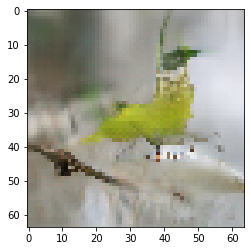

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 44

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.70421004295349 sec
Gen loss: 4.376101839510083, Gen valid loss: 1.2618759410168097, Gen attr loss: 1.5863349050041136, Gen caption loss: 1.527890985251119, Disc valid loss: 1.1042283132147337, Disc valid real loss: 0.5633863826915824, Disc valid fake loss: 0.5408419270502519, Disc attr loss: 2.8147937791134283, Disc attr real loss: 1.2284588741093148, Disc attr fake loss: 1.5863349050041136
Time for epoch 2 is 39.49250650405884 sec
Gen loss: 4.379409605248511, Gen valid loss: 1.2666786702344734, Gen attr loss: 1.587710849960968, Gen caption loss: 1.5250200798841027, Disc valid loss: 1.0945300984834914, Disc valid real loss: 0.5555917980063575, Disc valid fake loss: 0.5389382970042345, Disc attr loss: 2.8179189895549763, Disc attr real loss: 1.2302081395940083, Disc attr fake loss: 1.587710849960968
Time for epoch 3 is 39.91340947151184 sec
Gen loss

Time for epoch 21 is 39.65744471549988 sec
Gen loss: 4.402004908093915, Gen valid loss: 1.2672948032859865, Gen attr loss: 1.5979059818314343, Gen caption loss: 1.5368041077926553, Disc valid loss: 1.0978675229439567, Disc valid real loss: 0.5541147932935213, Disc valid fake loss: 0.5437527332040999, Disc attr loss: 2.826462284336245, Disc attr real loss: 1.228556302504811, Disc attr fake loss: 1.5979059818314343
Time for epoch 22 is 39.68744134902954 sec
Gen loss: 4.393697142924074, Gen valid loss: 1.2700447932814518, Gen attr loss: 1.591766219475082, Gen caption loss: 1.5318861178912444, Disc valid loss: 1.0957510119208151, Disc valid real loss: 0.5555540747274228, Disc valid fake loss: 0.5401969348512045, Disc attr loss: 2.819356444728407, Disc attr real loss: 1.2275902252533248, Disc attr fake loss: 1.591766219475082
Time for epoch 23 is 39.66983389854431 sec
Gen loss: 4.389621125327216, Gen valid loss: 1.268794720573477, Gen attr loss: 1.5908245035626378, Gen caption loss: 1.53000

Time for epoch 41 is 39.72900605201721 sec
Gen loss: 4.404186760506978, Gen valid loss: 1.2833033052240284, Gen attr loss: 1.5903288552431556, Gen caption loss: 1.5305545908325733, Disc valid loss: 1.0941757902220335, Disc valid real loss: 0.5556299121076176, Disc valid fake loss: 0.5385458784374765, Disc attr loss: 2.816230137496783, Disc attr real loss: 1.2259012822536273, Disc attr fake loss: 1.5903288552431556
Time for epoch 42 is 39.65549373626709 sec
Gen loss: 4.383072475753826, Gen valid loss: 1.2731767950988397, Gen attr loss: 1.585914360475411, Gen caption loss: 1.5239813117800043, Disc valid loss: 1.0989444769494903, Disc valid real loss: 0.5596387671422829, Disc valid fake loss: 0.5393057102110328, Disc attr loss: 2.8146979729657575, Disc attr real loss: 1.2287836124903464, Disc attr fake loss: 1.585914360475411
Time for epoch 43 is 39.67062044143677 sec
Gen loss: 4.381339535157532, Gen valid loss: 1.2653610567413371, Gen attr loss: 1.5894372275851283, Gen caption loss: 1.52

Time for epoch 61 is 39.65739727020264 sec
Gen loss: 4.396952883014834, Gen valid loss: 1.280187117051949, Gen attr loss: 1.588274917628384, Gen caption loss: 1.5284908493036824, Disc valid loss: 1.1011607779396906, Disc valid real loss: 0.5561316878330417, Disc valid fake loss: 0.5450290891374676, Disc attr loss: 2.813236301507407, Disc attr real loss: 1.2249613838790232, Disc attr fake loss: 1.588274917628384
Time for epoch 62 is 39.71317219734192 sec
Gen loss: 4.389051865756027, Gen valid loss: 1.2646848223396756, Gen attr loss: 1.592201655150106, Gen caption loss: 1.532165380674326, Disc valid loss: 1.0970337332748785, Disc valid real loss: 0.554179332362927, Disc valid fake loss: 0.5428544013965421, Disc attr loss: 2.819865408951674, Disc attr real loss: 1.227663753801568, Disc attr fake loss: 1.592201655150106
Time for epoch 63 is 39.656580209732056 sec
Gen loss: 4.379997579708978, Gen valid loss: 1.2601237990022676, Gen attr loss: 1.5899516418374329, Gen caption loss: 1.52992212

Time for epoch 81 is 39.44496154785156 sec
Gen loss: 4.373171067173242, Gen valid loss: 1.2509373736575367, Gen attr loss: 1.5893657927913718, Gen caption loss: 1.5328679016935147, Disc valid loss: 1.1104949900128331, Disc valid real loss: 0.5681596906366064, Disc valid fake loss: 0.5423352996992871, Disc attr loss: 2.8148591515171497, Disc attr real loss: 1.225493358725778, Disc attr fake loss: 1.5893657927913718
Time for epoch 82 is 39.35286259651184 sec
Gen loss: 4.395751199748135, Gen valid loss: 1.275946903357984, Gen attr loss: 1.5891586193224279, Gen caption loss: 1.5306456883748372, Disc valid loss: 1.0944126849252034, Disc valid real loss: 0.5573630635815907, Disc valid fake loss: 0.5370496222320288, Disc attr loss: 2.8157028457336635, Disc attr real loss: 1.2265442264112354, Disc attr fake loss: 1.5891586193224279
Time for epoch 83 is 39.82362627983093 sec
Gen loss: 4.3984699746780604, Gen valid loss: 1.275225456975663, Gen attr loss: 1.5890638618288324, Gen caption loss: 1.5

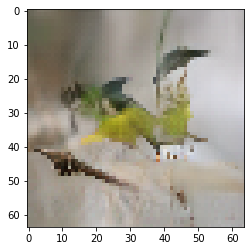

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 45

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.6132972240448 sec
Gen loss: 4.411558770874975, Gen valid loss: 1.2779948249418884, Gen attr loss: 1.5940919694538684, Gen caption loss: 1.5394719590339556, Disc valid loss: 1.0959014918422958, Disc valid real loss: 0.5570776277602849, Disc valid fake loss: 0.538823865778078, Disc attr loss: 2.8181076884915837, Disc attr real loss: 1.224015719037715, Disc attr fake loss: 1.5940919694538684
Time for epoch 2 is 39.45487928390503 sec
Gen loss: 4.394722448778023, Gen valid loss: 1.2678078114178768, Gen attr loss: 1.5926898669421188, Gen caption loss: 1.534224761210806, Disc valid loss: 1.0961782719061626, Disc valid real loss: 0.5557771623134613, Disc valid fake loss: 0.5404011083812248, Disc attr loss: 2.8224160146260973, Disc attr real loss: 1.2297261476839785, Disc attr fake loss: 1.5926898669421188
Time for epoch 3 is 39.68139696121216 sec
Gen loss:

Time for epoch 21 is 39.63255310058594 sec
Gen loss: 4.4104941388778895, Gen valid loss: 1.276340362179247, Gen attr loss: 1.5958395744080789, Gen caption loss: 1.53831419162957, Disc valid loss: 1.099234128062964, Disc valid real loss: 0.5546457784447244, Disc valid fake loss: 0.5445883470337566, Disc attr loss: 2.824048371495916, Disc attr real loss: 1.2282087970878373, Disc attr fake loss: 1.5958395744080789
Time for epoch 22 is 39.59424877166748 sec
Gen loss: 4.393279721743369, Gen valid loss: 1.2672055492879253, Gen attr loss: 1.5924986432884445, Gen caption loss: 1.5335755254518049, Disc valid loss: 1.0998472739364396, Disc valid real loss: 0.5577558267730361, Disc valid fake loss: 0.5420914482133499, Disc attr loss: 2.8182513455388345, Disc attr real loss: 1.2257527022503902, Disc attr fake loss: 1.5924986432884445
Time for epoch 23 is 39.34290146827698 sec
Gen loss: 4.394426554522217, Gen valid loss: 1.2733823114294347, Gen attr loss: 1.5914263534675122, Gen caption loss: 1.529

Time for epoch 41 is 39.61554551124573 sec
Gen loss: 4.376294887485866, Gen valid loss: 1.2553203950729475, Gen attr loss: 1.591075438147961, Gen caption loss: 1.5298990618568773, Disc valid loss: 1.1095348677337977, Disc valid real loss: 0.5611870289656528, Disc valid fake loss: 0.5483478370720778, Disc attr loss: 2.818129161509072, Disc attr real loss: 1.227053723361111, Disc attr fake loss: 1.591075438147961
Time for epoch 42 is 39.533949851989746 sec
Gen loss: 4.3808361456646185, Gen valid loss: 1.2582588914610182, Gen attr loss: 1.5914482456558765, Gen caption loss: 1.5311290067708911, Disc valid loss: 1.0991181119024591, Disc valid real loss: 0.5559598376272816, Disc valid fake loss: 0.543158274679003, Disc attr loss: 2.8161746796553695, Disc attr real loss: 1.2247264339994932, Disc attr fake loss: 1.5914482456558765
Time for epoch 43 is 39.769492864608765 sec
Gen loss: 4.377729032097793, Gen valid loss: 1.2628685274744422, Gen attr loss: 1.588173692788535, Gen caption loss: 1.52

Time for epoch 61 is 39.575453996658325 sec
Gen loss: 4.398344459895519, Gen valid loss: 1.2750434290748949, Gen attr loss: 1.5916798912735812, Gen caption loss: 1.5316211447160095, Disc valid loss: 1.099607367825702, Disc valid real loss: 0.5582524180250762, Disc valid fake loss: 0.5413549513351626, Disc attr loss: 2.8181710663203625, Disc attr real loss: 1.2264911750467813, Disc attr fake loss: 1.5916798912735812
Time for epoch 62 is 39.471163749694824 sec
Gen loss: 4.390054654945849, Gen valid loss: 1.2691446885183897, Gen attr loss: 1.5884966472300088, Gen caption loss: 1.5324133143515444, Disc valid loss: 1.0978771779272292, Disc valid real loss: 0.5595522534233445, Disc valid fake loss: 0.538324923211643, Disc attr loss: 2.8137479584391523, Disc attr real loss: 1.2252513112091437, Disc attr fake loss: 1.5884966472300088
Time for epoch 63 is 39.605446100234985 sec
Gen loss: 4.398990087715914, Gen valid loss: 1.2791260306428118, Gen attr loss: 1.5862636055726669, Gen caption loss: 

Time for epoch 81 is 39.61226034164429 sec
Gen loss: 4.3953694282831535, Gen valid loss: 1.268137039530891, Gen attr loss: 1.592050455126982, Gen caption loss: 1.5351819261948914, Disc valid loss: 1.1016871174822656, Disc valid real loss: 0.5607416764668979, Disc valid fake loss: 0.5409454416614884, Disc attr loss: 2.8162399289730766, Disc attr real loss: 1.2241894738460943, Disc attr fake loss: 1.592050455126982
Time for epoch 82 is 39.42374563217163 sec
Gen loss: 4.389882563252436, Gen valid loss: 1.2689648231839745, Gen attr loss: 1.5917363438179823, Gen caption loss: 1.5291813973811907, Disc valid loss: 1.0974500243902852, Disc valid real loss: 0.5558341354697054, Disc valid fake loss: 0.5416158881129288, Disc attr loss: 2.8157955739233227, Disc attr real loss: 1.2240592301053406, Disc attr fake loss: 1.5917363438179823
Time for epoch 83 is 39.68282079696655 sec
Gen loss: 4.375097057683681, Gen valid loss: 1.2670934432890357, Gen attr loss: 1.5830402067360194, Gen caption loss: 1.5

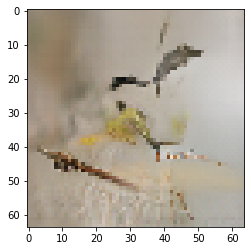

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 46

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.350632667541504 sec
Gen loss: 4.388434937975917, Gen valid loss: 1.2716358812843882, Gen attr loss: 1.5887854716319056, Gen caption loss: 1.5280135957206167, Disc valid loss: 1.0986829340296387, Disc valid real loss: 0.5563775609502302, Disc valid fake loss: 0.5423053699295696, Disc attr loss: 2.8128276950298607, Disc attr real loss: 1.2240422233979553, Disc attr fake loss: 1.5887854716319056
Time for epoch 2 is 39.51227140426636 sec
Gen loss: 4.390979706110347, Gen valid loss: 1.27788846699526, Gen attr loss: 1.5862071672429237, Gen caption loss: 1.5268840799486734, Disc valid loss: 1.0903906597677608, Disc valid real loss: 0.5541339624864945, Disc valid fake loss: 0.5362566988965684, Disc attr loss: 2.8120363706818763, Disc attr real loss: 1.2258292034389526, Disc attr fake loss: 1.5862071672429237
Time for epoch 3 is 39.701658725738525 sec
Gen l

Time for epoch 21 is 39.3341851234436 sec
Gen loss: 4.381588284562274, Gen valid loss: 1.2612730928552829, Gen attr loss: 1.5910005207630353, Gen caption loss: 1.5293146639981567, Disc valid loss: 1.104472330430659, Disc valid real loss: 0.5658534583522052, Disc valid fake loss: 0.5386188750667624, Disc attr loss: 2.816357142880034, Disc attr real loss: 1.2253566221169987, Disc attr fake loss: 1.5910005207630353
Time for epoch 22 is 39.65148663520813 sec
Gen loss: 4.386519055379439, Gen valid loss: 1.2679732676120954, Gen attr loss: 1.5891617436396075, Gen caption loss: 1.5293840534964873, Disc valid loss: 1.1000631643827692, Disc valid real loss: 0.557766873096709, Disc valid fake loss: 0.5422962900745837, Disc attr loss: 2.813693655538688, Disc attr real loss: 1.2245319118990807, Disc attr fake loss: 1.5891617436396075
Time for epoch 23 is 39.45745348930359 sec
Gen loss: 4.390621494794603, Gen valid loss: 1.271631768079308, Gen attr loss: 1.5901953431002815, Gen caption loss: 1.52879

Time for epoch 41 is 39.54267740249634 sec
Gen loss: 4.394414616794121, Gen valid loss: 1.2623701468715822, Gen attr loss: 1.5952020033911314, Gen caption loss: 1.536842459908669, Disc valid loss: 1.1034650718616599, Disc valid real loss: 0.5588621231437052, Disc valid fake loss: 0.5446029450835251, Disc attr loss: 2.8202023063571797, Disc attr real loss: 1.2250003029660481, Disc attr fake loss: 1.5952020033911314
Time for epoch 42 is 39.491902589797974 sec
Gen loss: 4.393104315450198, Gen valid loss: 1.2752494115816546, Gen attr loss: 1.5882188052665898, Gen caption loss: 1.5296360981173631, Disc valid loss: 1.0914106092801907, Disc valid real loss: 0.5565384407515125, Disc valid fake loss: 0.5348721694170944, Disc attr loss: 2.8110207272415884, Disc attr real loss: 1.2228019219749988, Disc attr fake loss: 1.5882188052665898
Time for epoch 43 is 39.467491149902344 sec
Gen loss: 4.39283875850481, Gen valid loss: 1.276346324582087, Gen attr loss: 1.5866431162609318, Gen caption loss: 1.

Time for epoch 61 is 39.44450521469116 sec
Gen loss: 4.3798095759983635, Gen valid loss: 1.2674575016750553, Gen attr loss: 1.5865295001161777, Gen caption loss: 1.525822564515318, Disc valid loss: 1.1022741070930875, Disc valid real loss: 0.5595950660343739, Disc valid fake loss: 0.5426790417048343, Disc attr loss: 2.8087796943620615, Disc attr real loss: 1.2222501942458837, Disc attr fake loss: 1.5865295001161777
Time for epoch 62 is 39.51153373718262 sec
Gen loss: 4.3813079572951565, Gen valid loss: 1.2609879715332817, Gen attr loss: 1.5903312849804638, Gen caption loss: 1.5299887014275322, Disc valid loss: 1.1106897526317172, Disc valid real loss: 0.5642030697851, Disc valid fake loss: 0.5464866825235568, Disc attr loss: 2.813899393327191, Disc attr real loss: 1.2235681083467271, Disc attr fake loss: 1.5903312849804638
Time for epoch 63 is 39.43727469444275 sec
Gen loss: 4.384238352297444, Gen valid loss: 1.2703656420152039, Gen attr loss: 1.5854219188535117, Gen caption loss: 1.52

Time for epoch 81 is 39.431599140167236 sec
Gen loss: 4.389269703448949, Gen valid loss: 1.2619289920582035, Gen attr loss: 1.5936048932191802, Gen caption loss: 1.5337358008878341, Disc valid loss: 1.104996297094557, Disc valid real loss: 0.5575739645214908, Disc valid fake loss: 0.5474223338653078, Disc attr loss: 2.8157216856473184, Disc attr real loss: 1.2221167924281382, Disc attr fake loss: 1.5936048932191802
Time for epoch 82 is 39.4317569732666 sec
Gen loss: 4.394538362497883, Gen valid loss: 1.2664159925649483, Gen attr loss: 1.5921172300974529, Gen caption loss: 1.5360051438737368, Disc valid loss: 1.0971499901153854, Disc valid real loss: 0.5578891928118419, Disc valid fake loss: 0.5392607969804831, Disc attr loss: 2.8149670436776426, Disc attr real loss: 1.22284981358019, Disc attr fake loss: 1.5921172300974529
Time for epoch 83 is 39.456791639328 sec
Gen loss: 4.406145532602864, Gen valid loss: 1.2756477804364874, Gen attr loss: 1.5941319058581096, Gen caption loss: 1.5363

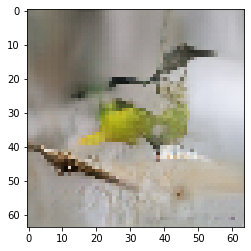

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 47

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.52449321746826 sec
Gen loss: 4.387197373682245, Gen valid loss: 1.2643902447165511, Gen attr loss: 1.5895117343602787, Gen caption loss: 1.5332954026819245, Disc valid loss: 1.101358020693306, Disc valid real loss: 0.5586286711337444, Disc valid fake loss: 0.5427293526286355, Disc attr loss: 2.8101634533424686, Disc attr real loss: 1.22065171898219, Disc attr fake loss: 1.5895117343602787
Time for epoch 2 is 39.2370491027832 sec
Gen loss: 4.395310144760422, Gen valid loss: 1.2724399264588913, Gen attr loss: 1.5888969633314345, Gen caption loss: 1.5339732399477868, Disc valid loss: 1.0952246103506424, Disc valid real loss: 0.5540580709129168, Disc valid fake loss: 0.541166540568437, Disc attr loss: 2.8123419441504853, Disc attr real loss: 1.2234449808190508, Disc attr fake loss: 1.5888969633314345
Time for epoch 3 is 39.28411841392517 sec
Gen loss: 

Time for epoch 21 is 39.426677942276 sec
Gen loss: 4.38341523056754, Gen valid loss: 1.2705891710632862, Gen attr loss: 1.5869823868681745, Gen caption loss: 1.5258436677901726, Disc valid loss: 1.1005896092430363, Disc valid real loss: 0.5559848433103018, Disc valid fake loss: 0.5446047654481438, Disc attr loss: 2.8087714950889753, Disc attr real loss: 1.2217891082208008, Disc attr fake loss: 1.5869823868681745
Time for epoch 22 is 39.40212535858154 sec
Gen loss: 4.4053346025265325, Gen valid loss: 1.2744688645287905, Gen attr loss: 1.595847333672893, Gen caption loss: 1.535018409493816, Disc valid loss: 1.0917165741364807, Disc valid real loss: 0.5543968621792832, Disc valid fake loss: 0.537319711553372, Disc attr loss: 2.8164509943507228, Disc attr real loss: 1.2206036606778297, Disc attr fake loss: 1.595847333672893
Time for epoch 23 is 39.55135369300842 sec
Gen loss: 4.3880094628993085, Gen valid loss: 1.2577668774095654, Gen attr loss: 1.5950696885101194, Gen caption loss: 1.5351

Time for epoch 41 is 39.37502717971802 sec
Gen loss: 4.389633822247265, Gen valid loss: 1.2747707570471414, Gen attr loss: 1.5861744050411029, Gen caption loss: 1.528688658220658, Disc valid loss: 1.097448428310353, Disc valid real loss: 0.5566748646378195, Disc valid fake loss: 0.5407735662570168, Disc attr loss: 2.8092322553076396, Disc attr real loss: 1.2230578502665368, Disc attr fake loss: 1.5861744050411029
Time for epoch 42 is 39.32588744163513 sec
Gen loss: 4.404250619857292, Gen valid loss: 1.27718503623797, Gen attr loss: 1.5939199485106843, Gen caption loss: 1.5331456347855772, Disc valid loss: 1.0934457011662202, Disc valid real loss: 0.5525297350515195, Disc valid fake loss: 0.5409159654685798, Disc attr loss: 2.8160120715616843, Disc attr real loss: 1.2220921230509998, Disc attr fake loss: 1.5939199485106843
Time for epoch 43 is 39.328869104385376 sec
Gen loss: 4.40757459095177, Gen valid loss: 1.279919550832371, Gen attr loss: 1.5921508910533213, Gen caption loss: 1.5355

Time for epoch 61 is 39.287354469299316 sec
Gen loss: 4.392754220704076, Gen valid loss: 1.27123702202386, Gen attr loss: 1.59171242862536, Gen caption loss: 1.5298047666627217, Disc valid loss: 1.1023056306813144, Disc valid real loss: 0.5590122382492231, Disc valid fake loss: 0.5432933936435679, Disc attr loss: 2.812058440714994, Disc attr real loss: 1.2203460120896337, Disc attr fake loss: 1.59171242862536
Time for epoch 62 is 39.28947162628174 sec
Gen loss: 4.3845446936806365, Gen valid loss: 1.2717681830814538, Gen attr loss: 1.5842920367310687, Gen caption loss: 1.528484456907443, Disc valid loss: 1.0931291381518047, Disc valid real loss: 0.5515698969848757, Disc valid fake loss: 0.5415592385016805, Disc attr loss: 2.80101719619782, Disc attr real loss: 1.2167251594667512, Disc attr fake loss: 1.5842920367310687
Time for epoch 63 is 39.30241584777832 sec
Gen loss: 4.38594078888415, Gen valid loss: 1.2671791240774841, Gen attr loss: 1.5892008701314124, Gen caption loss: 1.52956079

Time for epoch 81 is 39.32733392715454 sec
Gen loss: 4.386348481423809, Gen valid loss: 1.263980509465949, Gen attr loss: 1.5904598898357816, Gen caption loss: 1.5319080779222938, Disc valid loss: 1.1019201081619676, Disc valid real loss: 0.5585067621899168, Disc valid fake loss: 0.5434133477488831, Disc attr loss: 2.8128017062740276, Disc attr real loss: 1.2223418164382458, Disc attr fake loss: 1.5904598898357816
Time for epoch 82 is 39.279287576675415 sec
Gen loss: 4.394146189133973, Gen valid loss: 1.2798897822697957, Gen attr loss: 1.5863628057929557, Gen caption loss: 1.5278935926716501, Disc valid loss: 1.0917923077335203, Disc valid real loss: 0.556918394355593, Disc valid fake loss: 0.5348739143471085, Disc attr loss: 2.8083291381678284, Disc attr real loss: 1.2219663323748726, Disc attr fake loss: 1.5863628057929557
Time for epoch 83 is 39.26730990409851 sec
Gen loss: 4.4018893228959906, Gen valid loss: 1.2678066004259476, Gen attr loss: 1.5997765461603801, Gen caption loss: 1

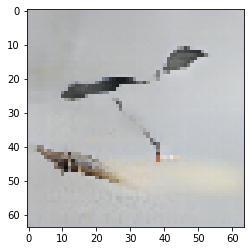

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 48

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.212026596069336 sec
Gen loss: 4.380059433500295, Gen valid loss: 1.2603363218669323, Gen attr loss: 1.5884152486072323, Gen caption loss: 1.5313078643183722, Disc valid loss: 1.1044819999516495, Disc valid real loss: 0.5622077525308139, Disc valid fake loss: 0.5422742468554799, Disc attr loss: 2.807930183766011, Disc attr real loss: 1.2195149351587786, Disc attr fake loss: 1.5884152486072323
Time for epoch 2 is 39.50418043136597 sec
Gen loss: 4.416617741752769, Gen valid loss: 1.2935636776895705, Gen attr loss: 1.5916882391544538, Gen caption loss: 1.5313658375081007, Disc valid loss: 1.083792045349028, Disc valid real loss: 0.5452455841913456, Disc valid fake loss: 0.5385464633383402, Disc attr loss: 2.81252538818654, Disc attr real loss: 1.2208371490320862, Disc attr fake loss: 1.5916882391544538
Time for epoch 3 is 39.35088586807251 sec
Gen loss

Time for epoch 21 is 39.32763886451721 sec
Gen loss: 4.4026285858981336, Gen valid loss: 1.2709209828518917, Gen attr loss: 1.5936996297138493, Gen caption loss: 1.5380079736554526, Disc valid loss: 1.0988887874737665, Disc valid real loss: 0.5543053573386133, Disc valid fake loss: 0.5445834322350458, Disc attr loss: 2.8148913861613285, Disc attr real loss: 1.2211917564474792, Disc attr fake loss: 1.5936996297138493
Time for epoch 22 is 39.34907269477844 sec
Gen loss: 4.404826739939248, Gen valid loss: 1.2779652679838784, Gen attr loss: 1.5920293201922078, Gen caption loss: 1.534832148371027, Disc valid loss: 1.0918058064894947, Disc valid real loss: 0.554860979480149, Disc valid fake loss: 0.5369448276554666, Disc attr loss: 2.8104658511272937, Disc attr real loss: 1.218436530935086, Disc attr fake loss: 1.5920293201922078
Time for epoch 23 is 39.35153818130493 sec
Gen loss: 4.400375066410882, Gen valid loss: 1.2782113269415651, Gen attr loss: 1.5898718388099982, Gen caption loss: 1.5

Time for epoch 41 is 39.337323904037476 sec
Gen loss: 4.3870393855138845, Gen valid loss: 1.2658650169204566, Gen attr loss: 1.591330092773851, Gen caption loss: 1.5298442811500736, Disc valid loss: 1.1065715129782514, Disc valid real loss: 0.5652413724399195, Disc valid fake loss: 0.5413301353693655, Disc attr loss: 2.8132481642854894, Disc attr real loss: 1.2219180715116382, Disc attr fake loss: 1.591330092773851
Time for epoch 42 is 39.27423620223999 sec
Gen loss: 4.400687774668541, Gen valid loss: 1.28529001412999, Gen attr loss: 1.588573092367591, Gen caption loss: 1.5268246662325975, Disc valid loss: 1.0861756026260252, Disc valid real loss: 0.5488458276602634, Disc valid fake loss: 0.5373297752888222, Disc attr loss: 2.8096081305971636, Disc attr real loss: 1.2210350382295727, Disc attr fake loss: 1.588573092367591
Time for epoch 43 is 39.41368627548218 sec
Gen loss: 4.39260977070506, Gen valid loss: 1.2689997445600143, Gen attr loss: 1.5907948349872578, Gen caption loss: 1.5328

Time for epoch 61 is 39.31895446777344 sec
Gen loss: 4.387067600317441, Gen valid loss: 1.2705329756749677, Gen attr loss: 1.5874449861081958, Gen caption loss: 1.5290896414418207, Disc valid loss: 1.099422273597097, Disc valid real loss: 0.5587406272326059, Disc valid fake loss: 0.5406816456376052, Disc attr loss: 2.8043484319516314, Disc attr real loss: 1.2169034458434356, Disc attr fake loss: 1.5874449861081958
Time for epoch 62 is 39.30405235290527 sec
Gen loss: 4.397798009035064, Gen valid loss: 1.2799900398667912, Gen attr loss: 1.5900951384851927, Gen caption loss: 1.5277128364981674, Disc valid loss: 1.0906176192327566, Disc valid real loss: 0.5519957875979302, Disc valid fake loss: 0.5386218309887056, Disc attr loss: 2.8084206634420688, Disc attr real loss: 1.2183255249568763, Disc attr fake loss: 1.5900951384851927
Time for epoch 63 is 39.33406949043274 sec
Gen loss: 4.384498693755648, Gen valid loss: 1.2681457172564374, Gen attr loss: 1.5879123214137587, Gen caption loss: 1.

Time for epoch 81 is 39.32910633087158 sec
Gen loss: 4.40252661640405, Gen valid loss: 1.2833803299319777, Gen attr loss: 1.5887255927088462, Gen caption loss: 1.5304206929555753, Disc valid loss: 1.0917347340079826, Disc valid real loss: 0.549871571099532, Disc valid fake loss: 0.5418631604047326, Disc attr loss: 2.808186314131832, Disc attr real loss: 1.2194607214229862, Disc attr fake loss: 1.5887255927088462
Time for epoch 82 is 39.31678342819214 sec
Gen loss: 4.383739589675655, Gen valid loss: 1.2592843927665132, Gen attr loss: 1.58823748978819, Gen caption loss: 1.5362177014673952, Disc valid loss: 1.1096765260063213, Disc valid real loss: 0.5647998920624172, Disc valid fake loss: 0.5448766311978906, Disc attr loss: 2.8098096826535253, Disc attr real loss: 1.2215721928653356, Disc attr fake loss: 1.58823748978819
Time for epoch 83 is 39.3149254322052 sec
Gen loss: 4.395185888621219, Gen valid loss: 1.2718480337602982, Gen attr loss: 1.5901434111401318, Gen caption loss: 1.5331944

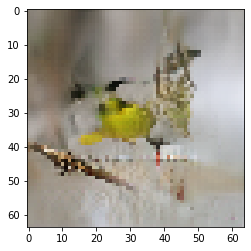

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 49

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.31649827957153 sec
Gen loss: 4.381866571379871, Gen valid loss: 1.2619360662734282, Gen attr loss: 1.590274700304357, Gen caption loss: 1.529655805125146, Disc valid loss: 1.1013960499104445, Disc valid real loss: 0.5585372300167394, Disc valid fake loss: 0.5428588218320676, Disc attr loss: 2.8106106248328357, Disc attr real loss: 1.2203359245284786, Disc attr fake loss: 1.590274700304357
Time for epoch 2 is 39.19493865966797 sec
Gen loss: 4.403756820089448, Gen valid loss: 1.284403822124812, Gen attr loss: 1.5896369616190593, Gen caption loss: 1.529716040706893, Disc valid loss: 1.0886248627975381, Disc valid real loss: 0.5532946342698281, Disc valid fake loss: 0.5353302303045423, Disc attr loss: 2.8086053979429124, Disc attr real loss: 1.2189684363238533, Disc attr fake loss: 1.5896369616190593
Time for epoch 3 is 39.496755838394165 sec
Gen loss:

Time for epoch 21 is 39.298566818237305 sec
Gen loss: 4.3879266760859705, Gen valid loss: 1.2641568645875305, Gen attr loss: 1.589410444262228, Gen caption loss: 1.5343593762819037, Disc valid loss: 1.106671106686114, Disc valid real loss: 0.5600589595351438, Disc valid fake loss: 0.5466121471509701, Disc attr loss: 2.8064904001347095, Disc attr real loss: 1.2170799558724814, Disc attr fake loss: 1.589410444262228
Time for epoch 22 is 39.26666069030762 sec
Gen loss: 4.394513749817846, Gen valid loss: 1.2767284270224533, Gen attr loss: 1.5865446988160048, Gen caption loss: 1.531240615418287, Disc valid loss: 1.0911340432438423, Disc valid real loss: 0.5522363928113849, Disc valid fake loss: 0.5388976529361756, Disc attr loss: 2.8022531385667278, Disc attr real loss: 1.2157084397507232, Disc attr fake loss: 1.5865446988160048
Time for epoch 23 is 39.25901007652283 sec
Gen loss: 4.404407686011255, Gen valid loss: 1.2876295662184718, Gen attr loss: 1.5875563560139518, Gen caption loss: 1.5

Time for epoch 41 is 39.298722982406616 sec
Gen loss: 4.375277289853186, Gen valid loss: 1.2625659303613472, Gen attr loss: 1.585980925133558, Gen caption loss: 1.526730448249879, Disc valid loss: 1.1048834144584532, Disc valid real loss: 0.5585963257606114, Disc valid fake loss: 0.5462870886978418, Disc attr loss: 2.8058372928198114, Disc attr real loss: 1.2198563676862535, Disc attr fake loss: 1.585980925133558
Time for epoch 42 is 39.294148683547974 sec
Gen loss: 4.361755239285104, Gen valid loss: 1.2467551869428577, Gen attr loss: 1.5861565847060868, Gen caption loss: 1.5288434519677305, Disc valid loss: 1.110312617729673, Disc valid real loss: 0.563492987940951, Disc valid fake loss: 0.5468196310001984, Disc attr loss: 2.8040261875969286, Disc attr real loss: 1.2178696028908418, Disc attr fake loss: 1.5861565847060868
Time for epoch 43 is 39.339927673339844 sec
Gen loss: 4.388506796947985, Gen valid loss: 1.2717970052385719, Gen attr loss: 1.5879363490314018, Gen caption loss: 1.5

Time for epoch 61 is 39.14087700843811 sec
Gen loss: 4.395402041231067, Gen valid loss: 1.2743807984238396, Gen attr loss: 1.589099285402272, Gen caption loss: 1.531921966935238, Disc valid loss: 1.1018771716572728, Disc valid real loss: 0.5579502387906154, Disc valid fake loss: 0.5439269321397714, Disc attr loss: 2.8059613701450794, Disc attr real loss: 1.216862084742807, Disc attr fake loss: 1.589099285402272
Time for epoch 62 is 39.13734173774719 sec
Gen loss: 4.385087209665356, Gen valid loss: 1.2698250711771855, Gen attr loss: 1.5867929907672127, Gen caption loss: 1.528469146751776, Disc valid loss: 1.097603065696189, Disc valid real loss: 0.5597264257872977, Disc valid fake loss: 0.5378766399088913, Disc attr loss: 2.805192598805518, Disc attr real loss: 1.2183996080383053, Disc attr fake loss: 1.5867929907672127
Time for epoch 63 is 39.14792799949646 sec
Gen loss: 4.381775829527113, Gen valid loss: 1.26057441060136, Gen attr loss: 1.5898615764731636, Gen caption loss: 1.53133983

Time for epoch 81 is 39.1708025932312 sec
Gen loss: 4.384668893607328, Gen valid loss: 1.26074707378863, Gen attr loss: 1.5911050285427228, Gen caption loss: 1.5328168022600293, Disc valid loss: 1.0988749709878833, Disc valid real loss: 0.5549119889413116, Disc valid fake loss: 0.5439629843887598, Disc attr loss: 2.807582419093062, Disc attr real loss: 1.2164773905503394, Disc attr fake loss: 1.5911050285427228
Time for epoch 82 is 39.2140634059906 sec
Gen loss: 4.388563636841813, Gen valid loss: 1.2753394945527157, Gen attr loss: 1.586833288352987, Gen caption loss: 1.5263908494132643, Disc valid loss: 1.0965927243232727, Disc valid real loss: 0.5561387200504138, Disc valid fake loss: 0.5404540026575569, Disc attr loss: 2.804429140355852, Disc attr real loss: 1.217595852002865, Disc attr fake loss: 1.586833288352987
Time for epoch 83 is 39.18771266937256 sec
Gen loss: 4.389132726483229, Gen valid loss: 1.2702911618925368, Gen attr loss: 1.589086409506759, Gen caption loss: 1.529755151

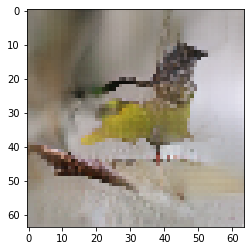

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 50

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.289923667907715 sec
Gen loss: 4.389432899997163, Gen valid loss: 1.265518080574387, Gen attr loss: 1.5924955415854931, Gen caption loss: 1.5314192800987056, Disc valid loss: 1.1058057470696405, Disc valid real loss: 0.5629955234566355, Disc valid fake loss: 0.5428102236937701, Disc attr loss: 2.8094846036052963, Disc attr real loss: 1.216989062019803, Disc attr fake loss: 1.5924955415854931
Time for epoch 2 is 39.36098003387451 sec
Gen loss: 4.381635106352933, Gen valid loss: 1.260049124074176, Gen attr loss: 1.5906473194680564, Gen caption loss: 1.5309386699180292, Disc valid loss: 1.102279209186068, Disc valid real loss: 0.5607527704419806, Disc valid fake loss: 0.5415264382594969, Disc attr loss: 2.808320687553747, Disc attr real loss: 1.2176733680856906, Disc attr fake loss: 1.5906473194680564
Time for epoch 3 is 39.100834369659424 sec
Gen loss

Time for epoch 21 is 39.31928992271423 sec
Gen loss: 4.389134496208129, Gen valid loss: 1.2726449990660194, Gen attr loss: 1.5892308901965133, Gen caption loss: 1.5272586051687638, Disc valid loss: 1.0996896631026332, Disc valid real loss: 0.5585285513220117, Disc valid fake loss: 0.5411611120229168, Disc attr loss: 2.808007951351362, Disc attr real loss: 1.2187770611548487, Disc attr fake loss: 1.5892308901965133
Time for epoch 22 is 39.29561233520508 sec
Gen loss: 4.391682896833756, Gen valid loss: 1.2680614941165376, Gen attr loss: 1.5924056939639373, Gen caption loss: 1.5312157142453078, Disc valid loss: 1.094516484233422, Disc valid real loss: 0.5553492773677599, Disc valid fake loss: 0.53916720508883, Disc attr loss: 2.805646132970567, Disc attr real loss: 1.2132404390066296, Disc attr fake loss: 1.5924056939639373
Time for epoch 23 is 39.05652856826782 sec
Gen loss: 4.396829433880524, Gen valid loss: 1.2734957027241467, Gen attr loss: 1.5924614044385874, Gen caption loss: 1.5308

Time for epoch 41 is 39.207308530807495 sec
Gen loss: 4.401895974063615, Gen valid loss: 1.275440801126847, Gen attr loss: 1.5906999237169095, Gen caption loss: 1.5357552511582206, Disc valid loss: 1.1004066722502877, Disc valid real loss: 0.5601547831280768, Disc valid fake loss: 0.5402518895260364, Disc attr loss: 2.8059512724075213, Disc attr real loss: 1.2152513486906118, Disc attr fake loss: 1.5906999237169095
Time for epoch 42 is 39.246423959732056 sec
Gen loss: 4.38819043293878, Gen valid loss: 1.271203882002895, Gen attr loss: 1.5877134654580094, Gen caption loss: 1.5292730848317546, Disc valid loss: 1.0940912373989902, Disc valid real loss: 0.5559171440640116, Disc valid fake loss: 0.5381740950310456, Disc attr loss: 2.8055510971604325, Disc attr real loss: 1.217837631702423, Disc attr fake loss: 1.5877134654580094
Time for epoch 43 is 39.46068263053894 sec
Gen loss: 4.37371638861452, Gen valid loss: 1.2632403525556652, Gen attr loss: 1.585850808032483, Gen caption loss: 1.524

Time for epoch 61 is 39.2627968788147 sec
Gen loss: 4.377842963872563, Gen valid loss: 1.262035612168351, Gen attr loss: 1.5883357612098135, Gen caption loss: 1.5274715921097008, Disc valid loss: 1.1078032033876353, Disc valid real loss: 0.5641782689223768, Disc valid fake loss: 0.5436249343844933, Disc attr loss: 2.8038299358311063, Disc attr real loss: 1.2154941746212926, Disc attr fake loss: 1.5883357612098135
Time for epoch 62 is 39.31122303009033 sec
Gen loss: 4.373929245362114, Gen valid loss: 1.25245459050667, Gen attr loss: 1.5923073411310915, Gen caption loss: 1.529167320670151, Disc valid loss: 1.1040593810520845, Disc valid real loss: 0.5593618790954755, Disc valid fake loss: 0.5446974995336559, Disc attr loss: 2.8088591055172247, Disc attr real loss: 1.2165517643861332, Disc attr fake loss: 1.5923073411310915
Time for epoch 63 is 39.26610279083252 sec
Gen loss: 4.387489099812702, Gen valid loss: 1.2732294570139753, Gen attr loss: 1.5884297204211475, Gen caption loss: 1.5258

Time for epoch 81 is 39.2688729763031 sec
Gen loss: 4.385146057702662, Gen valid loss: 1.2671511790293666, Gen attr loss: 1.5887504854822547, Gen caption loss: 1.5292444103132419, Disc valid loss: 1.104479420152783, Disc valid real loss: 0.5561317268425856, Disc valid fake loss: 0.5483476906449491, Disc attr loss: 2.8051829741899237, Disc attr real loss: 1.216432488707669, Disc attr fake loss: 1.5887504854822547
Time for epoch 82 is 39.28046202659607 sec
Gen loss: 4.388715432588324, Gen valid loss: 1.271057493156857, Gen attr loss: 1.5901434541071657, Gen caption loss: 1.5275144715942341, Disc valid loss: 1.0967273196876857, Disc valid real loss: 0.5563941546248873, Disc valid fake loss: 0.5403331670011609, Disc attr loss: 2.804166505976421, Disc attr real loss: 1.2140230518692554, Disc attr fake loss: 1.5901434541071657
Time for epoch 83 is 39.33968997001648 sec
Gen loss: 4.398403992174764, Gen valid loss: 1.273177814031358, Gen attr loss: 1.5914944959526787, Gen caption loss: 1.53373

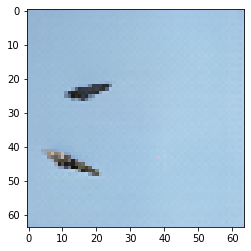

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 51

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.33902645111084 sec
Gen loss: 4.379435906888347, Gen valid loss: 1.2653387146913586, Gen attr loss: 1.5857934441346786, Gen caption loss: 1.5283037482238397, Disc valid loss: 1.1024484636014715, Disc valid real loss: 0.5584387837386713, Disc valid fake loss: 0.5440096808319815, Disc attr loss: 2.801909769130593, Disc attr real loss: 1.2161163249959144, Disc attr fake loss: 1.5857934441346786
Time for epoch 2 is 39.45772624015808 sec
Gen loss: 4.391084345375619, Gen valid loss: 1.2763530106402348, Gen attr loss: 1.5877069874507626, Gen caption loss: 1.5270243295162997, Disc valid loss: 1.0931052977476663, Disc valid real loss: 0.5551354010415271, Disc valid fake loss: 0.5379698949293069, Disc attr loss: 2.8048432170537105, Disc attr real loss: 1.2171362296029482, Disc attr fake loss: 1.5877069874507626
Time for epoch 3 is 39.259759187698364 sec
Gen l

Time for epoch 21 is 39.328566551208496 sec
Gen loss: 4.39974670746139, Gen valid loss: 1.2819360271701967, Gen attr loss: 1.5904677421419924, Gen caption loss: 1.5273429271651477, Disc valid loss: 1.097098102414511, Disc valid real loss: 0.5572859457514796, Disc valid fake loss: 0.5398121572283872, Disc attr loss: 2.8062452257164128, Disc attr real loss: 1.2157774835744202, Disc attr fake loss: 1.5904677421419924
Time for epoch 22 is 39.35993504524231 sec
Gen loss: 4.405312506487053, Gen valid loss: 1.2823359759519417, Gen attr loss: 1.5911134801259854, Gen caption loss: 1.5318630478246424, Disc valid loss: 1.0904063664800752, Disc valid real loss: 0.5549418477185051, Disc valid fake loss: 0.535464515450201, Disc attr loss: 2.8044072735277297, Disc attr real loss: 1.213293793401744, Disc attr fake loss: 1.5911134801259854
Time for epoch 23 is 39.351298332214355 sec
Gen loss: 4.401563272889714, Gen valid loss: 1.2775377836330797, Gen attr loss: 1.5924131821810714, Gen caption loss: 1.5

Time for epoch 41 is 39.44212746620178 sec
Gen loss: 4.404372572575804, Gen valid loss: 1.2823882498715304, Gen attr loss: 1.5906122699985659, Gen caption loss: 1.5313720622359899, Disc valid loss: 1.0970159161704665, Disc valid real loss: 0.5556767414901961, Disc valid fake loss: 0.5413391775878141, Disc attr loss: 2.8051441733430074, Disc attr real loss: 1.2145319033444413, Disc attr fake loss: 1.5906122699985659
Time for epoch 42 is 39.394707441329956 sec
Gen loss: 4.401008174994451, Gen valid loss: 1.2724606835745214, Gen attr loss: 1.5930189472549976, Gen caption loss: 1.5355285402882066, Disc valid loss: 1.0966233397887004, Disc valid real loss: 0.5577390353854109, Disc valid fake loss: 0.538884303191813, Disc attr loss: 2.8078887876133285, Disc attr real loss: 1.214869840358331, Disc attr fake loss: 1.5930189472549976
Time for epoch 43 is 39.40028119087219 sec
Gen loss: 4.394397117904208, Gen valid loss: 1.2756885416139432, Gen attr loss: 1.5893242491616144, Gen caption loss: 1.

Time for epoch 61 is 39.408935546875 sec
Gen loss: 4.380095171088449, Gen valid loss: 1.2711176269745763, Gen attr loss: 1.5821271091295774, Gen caption loss: 1.526850429330738, Disc valid loss: 1.0986107431130034, Disc valid real loss: 0.557968989781894, Disc valid fake loss: 0.5406417532503444, Disc attr loss: 2.7987261377375945, Disc attr real loss: 1.2165990286080173, Disc attr fake loss: 1.5821271091295774
Time for epoch 62 is 39.441819190979004 sec
Gen loss: 4.3910729019299435, Gen valid loss: 1.2658615002464149, Gen attr loss: 1.5903722471014916, Gen caption loss: 1.5348391591048822, Disc valid loss: 1.0976170156060197, Disc valid real loss: 0.5562917207314716, Disc valid fake loss: 0.5413252944707224, Disc attr loss: 2.803396197192391, Disc attr real loss: 1.2130239500908995, Disc attr fake loss: 1.5903722471014916
Time for epoch 63 is 39.40188908576965 sec
Gen loss: 4.387393100474908, Gen valid loss: 1.2661577312926935, Gen attr loss: 1.5880392524931166, Gen caption loss: 1.53

Time for epoch 81 is 39.58764338493347 sec
Gen loss: 4.382074467211881, Gen valid loss: 1.2602464538925708, Gen attr loss: 1.5918567132174484, Gen caption loss: 1.5299712871794455, Disc valid loss: 1.1084159914717118, Disc valid real loss: 0.5625722885616427, Disc valid fake loss: 0.5458437040407806, Disc attr loss: 2.8072284304998756, Disc attr real loss: 1.215371717282427, Disc attr fake loss: 1.5918567132174484
Time for epoch 82 is 39.532922983169556 sec
Gen loss: 4.364380475305284, Gen valid loss: 1.2468071969220955, Gen attr loss: 1.5888753240993676, Gen caption loss: 1.5286979407152832, Disc valid loss: 1.1049110322463802, Disc valid real loss: 0.560269836568574, Disc valid fake loss: 0.5446411976969339, Disc attr loss: 2.80241878908178, Disc attr real loss: 1.2135434649824126, Disc attr fake loss: 1.5888753240993676
Time for epoch 83 is 39.537841796875 sec
Gen loss: 4.379748633237389, Gen valid loss: 1.2589498060505564, Gen attr loss: 1.591411072710342, Gen caption loss: 1.52938

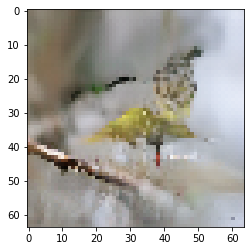

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 52

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.6713593006134 sec
Gen loss: 4.418387258602029, Gen valid loss: 1.2863940974561179, Gen attr loss: 1.596726306085664, Gen caption loss: 1.5352668377765148, Disc valid loss: 1.0952452558489028, Disc valid real loss: 0.5578227543895483, Disc valid fake loss: 0.537422501217059, Disc attr loss: 2.810757931331955, Disc attr real loss: 1.2140316252462908, Disc attr fake loss: 1.596726306085664
Time for epoch 2 is 39.4929678440094 sec
Gen loss: 4.414845905975921, Gen valid loss: 1.2920119419976626, Gen attr loss: 1.590157079502819, Gen caption loss: 1.532676889967466, Disc valid loss: 1.0878093898457886, Disc valid real loss: 0.5501156773185989, Disc valid fake loss: 0.5376937100234717, Disc attr loss: 2.8063180997442747, Disc attr real loss: 1.2161610202414557, Disc attr fake loss: 1.590157079502819
Time for epoch 3 is 39.722952127456665 sec
Gen loss: 4.3

Time for epoch 21 is 39.71384048461914 sec
Gen loss: 4.366272638806806, Gen valid loss: 1.248082142535264, Gen attr loss: 1.5885532483821962, Gen caption loss: 1.529637258550339, Disc valid loss: 1.1104632569199333, Disc valid real loss: 0.5661950159848221, Disc valid fake loss: 0.5442682427119433, Disc attr loss: 2.80347385138354, Disc attr real loss: 1.2149206030013437, Disc attr fake loss: 1.5885532483821962
Time for epoch 22 is 39.75766706466675 sec
Gen loss: 4.382282085211942, Gen valid loss: 1.2698100178545406, Gen attr loss: 1.5865514268720053, Gen caption loss: 1.5259206450082423, Disc valid loss: 1.0969589078006383, Disc valid real loss: 0.556993262635337, Disc valid fake loss: 0.5399656466998382, Disc attr loss: 2.800695968837273, Disc attr real loss: 1.2141445419652674, Disc attr fake loss: 1.5865514268720053
Time for epoch 23 is 39.752129793167114 sec
Gen loss: 4.4029985243065894, Gen valid loss: 1.281410766326315, Gen attr loss: 1.5886249716688947, Gen caption loss: 1.5329

Time for epoch 41 is 39.78285360336304 sec
Gen loss: 4.3890432238901855, Gen valid loss: 1.2736088021337824, Gen attr loss: 1.5879308463435187, Gen caption loss: 1.5275035657210725, Disc valid loss: 1.0994079712283644, Disc valid real loss: 0.5548381026844346, Disc valid fake loss: 0.5445698679785741, Disc attr loss: 2.8015161218035836, Disc attr real loss: 1.213585275460065, Disc attr fake loss: 1.5879308463435187
Time for epoch 42 is 39.724353075027466 sec
Gen loss: 4.394405780445916, Gen valid loss: 1.2718564452840706, Gen attr loss: 1.592406304225043, Gen caption loss: 1.5301430428900369, Disc valid loss: 1.0955524904941156, Disc valid real loss: 0.5546263517726081, Disc valid fake loss: 0.5409261388022725, Disc attr loss: 2.806310043586948, Disc attr real loss: 1.2139037393619052, Disc attr fake loss: 1.592406304225043
Time for epoch 43 is 39.75823640823364 sec
Gen loss: 4.376570207316701, Gen valid loss: 1.2611098103730014, Gen attr loss: 1.5860708489973694, Gen caption loss: 1.5

Time for epoch 61 is 39.981048345565796 sec
Gen loss: 4.360601151215675, Gen valid loss: 1.2499831160555688, Gen attr loss: 1.5854658528072079, Gen caption loss: 1.5251521786377036, Disc valid loss: 1.1064961912832285, Disc valid real loss: 0.5634131194937843, Disc valid fake loss: 0.5430830725163303, Disc attr loss: 2.800117832373797, Disc attr real loss: 1.2146519795665895, Disc attr fake loss: 1.5854658528072079
Time for epoch 62 is 39.846702098846436 sec
Gen loss: 4.3838824618476515, Gen valid loss: 1.2711587288192294, Gen attr loss: 1.587246322696448, Gen caption loss: 1.5254774074244306, Disc valid loss: 1.0965271989504497, Disc valid real loss: 0.5528678341609675, Disc valid fake loss: 0.5436593660009585, Disc attr loss: 2.7999349963374254, Disc attr real loss: 1.2126886736409774, Disc attr fake loss: 1.587246322696448
Time for epoch 63 is 39.821688175201416 sec
Gen loss: 4.404493785485989, Gen valid loss: 1.2821800521395716, Gen attr loss: 1.5903722038113974, Gen caption loss: 

Time for epoch 81 is 39.80993032455444 sec
Gen loss: 4.406627165915843, Gen valid loss: 1.286051344096176, Gen attr loss: 1.589213710490281, Gen caption loss: 1.531362115852232, Disc valid loss: 1.0950691691905179, Disc valid real loss: 0.5540470014096599, Disc valid fake loss: 0.5410221672155023, Disc attr loss: 2.802745980298939, Disc attr real loss: 1.2135322698086581, Disc attr fake loss: 1.589213710490281
Time for epoch 82 is 39.87527894973755 sec
Gen loss: 4.381466788651174, Gen valid loss: 1.2628704217391284, Gen attr loss: 1.5881310501072787, Gen caption loss: 1.5304653147048743, Disc valid loss: 1.1009604410750433, Disc valid real loss: 0.5542284752618329, Disc valid fake loss: 0.5467319655709151, Disc attr loss: 2.8004093989124144, Disc attr real loss: 1.2122783488051354, Disc attr fake loss: 1.5881310501072787
Time for epoch 83 is 40.17422866821289 sec
Gen loss: 4.410655315652449, Gen valid loss: 1.2877860851081082, Gen attr loss: 1.5904824497900034, Gen caption loss: 1.5323

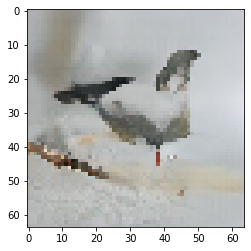

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 53

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.92619776725769 sec
Gen loss: 4.401779386086193, Gen valid loss: 1.2789909313041665, Gen attr loss: 1.5901089528711831, Gen caption loss: 1.532679502880024, Disc valid loss: 1.0963435197264197, Disc valid real loss: 0.5568906538047118, Disc valid fake loss: 0.5394528668908892, Disc attr loss: 2.8029544973761085, Disc attr real loss: 1.2128455445049255, Disc attr fake loss: 1.5901089528711831
Time for epoch 2 is 39.86643075942993 sec
Gen loss: 4.378130154881051, Gen valid loss: 1.2580200273816178, Gen attr loss: 1.5877262311899243, Gen caption loss: 1.5323838851639249, Disc valid loss: 1.108049163650368, Disc valid real loss: 0.562268554195156, Disc valid fake loss: 0.5457806080822053, Disc attr loss: 2.8008395205668317, Disc attr real loss: 1.2131132893769077, Disc attr fake loss: 1.5877262311899243
Time for epoch 3 is 39.87752294540405 sec
Gen loss

Time for epoch 21 is 40.028918743133545 sec
Gen loss: 4.389555915584409, Gen valid loss: 1.2706995472352356, Gen attr loss: 1.5901984735556087, Gen caption loss: 1.5286578802558464, Disc valid loss: 1.1015581659831328, Disc valid real loss: 0.5603833037017161, Disc valid fake loss: 0.5411748642197792, Disc attr loss: 2.800241947981723, Disc attr real loss: 1.2100434744261144, Disc attr fake loss: 1.5901984735556087
Time for epoch 22 is 40.05864119529724 sec
Gen loss: 4.3868907176382175, Gen valid loss: 1.2632891954122196, Gen attr loss: 1.5924494702641556, Gen caption loss: 1.5311520548693855, Disc valid loss: 1.1047444403333069, Disc valid real loss: 0.5613056441471183, Disc valid fake loss: 0.5434387965900142, Disc attr loss: 2.8054423164222944, Disc attr real loss: 1.2129928461581387, Disc attr fake loss: 1.5924494702641556
Time for epoch 23 is 40.004090547561646 sec
Gen loss: 4.381170893749247, Gen valid loss: 1.2621642351150513, Gen attr loss: 1.587978677697944, Gen caption loss: 

Time for epoch 41 is 40.01666045188904 sec
Gen loss: 4.399790188807459, Gen valid loss: 1.271660511248157, Gen attr loss: 1.5923431077946815, Gen caption loss: 1.535786581233265, Disc valid loss: 1.101954389232284, Disc valid real loss: 0.558709130942983, Disc valid fake loss: 0.5432452586931265, Disc attr loss: 2.80491997071398, Disc attr real loss: 1.2125768629192983, Disc attr fake loss: 1.5923431077946815
Time for epoch 42 is 40.036365032196045 sec
Gen loss: 4.385291073703508, Gen valid loss: 1.2652618749354914, Gen attr loss: 1.5867612807731317, Gen caption loss: 1.5332679186410052, Disc valid loss: 1.100852938686929, Disc valid real loss: 0.5588243451060319, Disc valid fake loss: 0.542028595034669, Disc attr loss: 2.798584433105903, Disc attr real loss: 1.2118231523327712, Disc attr fake loss: 1.5867612807731317
Time for epoch 43 is 40.06806921958923 sec
Gen loss: 4.384880828986646, Gen valid loss: 1.2653442068797787, Gen attr loss: 1.5881186326344807, Gen caption loss: 1.5314179

Time for epoch 61 is 40.184751987457275 sec
Gen loss: 4.413492793959331, Gen valid loss: 1.2859458714965883, Gen attr loss: 1.5936731490985487, Gen caption loss: 1.5338737738487844, Disc valid loss: 1.0976510957327639, Disc valid real loss: 0.5529799723043675, Disc valid fake loss: 0.5446711268205306, Disc attr loss: 2.8047635826638073, Disc attr real loss: 1.2110904335652586, Disc attr fake loss: 1.5936731490985487
Time for epoch 62 is 39.839067697525024 sec
Gen loss: 4.382473504963283, Gen valid loss: 1.2663694923809228, Gen attr loss: 1.5878572431683218, Gen caption loss: 1.5282467700601594, Disc valid loss: 1.0945836680368357, Disc valid real loss: 0.5545179783328762, Disc valid fake loss: 0.5400656901077849, Disc attr loss: 2.7984171044535753, Disc attr real loss: 1.2105598612852535, Disc attr fake loss: 1.5878572431683218
Time for epoch 63 is 40.12816023826599 sec
Gen loss: 4.419558811316969, Gen valid loss: 1.2956116871459051, Gen attr loss: 1.5905552210846567, Gen caption loss:

Time for epoch 81 is 39.70458769798279 sec
Gen loss: 4.385589313377856, Gen valid loss: 1.2668735903453052, Gen attr loss: 1.589319730838786, Gen caption loss: 1.52939600447006, Disc valid loss: 1.1024591840379607, Disc valid real loss: 0.5574748622692698, Disc valid fake loss: 0.5449843203149191, Disc attr loss: 2.7998147697306583, Disc attr real loss: 1.2104950388918725, Disc attr fake loss: 1.589319730838786
Time for epoch 82 is 40.16735076904297 sec
Gen loss: 4.394838999280439, Gen valid loss: 1.2705534184528238, Gen attr loss: 1.5914469162623088, Gen caption loss: 1.5328386702188632, Disc valid loss: 1.099271585301655, Disc valid real loss: 0.5556408148309403, Disc valid fake loss: 0.543630773055198, Disc attr loss: 2.8022473213795402, Disc attr real loss: 1.2108004051172314, Disc attr fake loss: 1.5914469162623088
Time for epoch 83 is 39.843098163604736 sec
Gen loss: 4.40884650948894, Gen valid loss: 1.2734040396646433, Gen attr loss: 1.5981113303321486, Gen caption loss: 1.53733

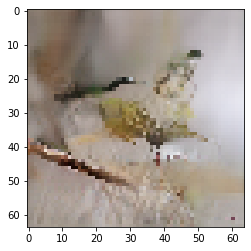

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 54

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.792365312576294 sec
Gen loss: 4.3963256903134065, Gen valid loss: 1.2742768356470557, Gen attr loss: 1.5916767892475696, Gen caption loss: 1.5303720768874254, Disc valid loss: 1.1044809995951046, Disc valid real loss: 0.5620414502413938, Disc valid fake loss: 0.5424395480614691, Disc attr loss: 2.8028136876217395, Disc attr real loss: 1.2111368983741697, Disc attr fake loss: 1.5916767892475696
Time for epoch 2 is 39.795047998428345 sec
Gen loss: 4.391920245436795, Gen valid loss: 1.2648679794980904, Gen attr loss: 1.5935800001227112, Gen caption loss: 1.5334722640391611, Disc valid loss: 1.095182468897605, Disc valid real loss: 0.5551366820567991, Disc valid fake loss: 0.5400457871638662, Disc attr loss: 2.8050286030058613, Disc attr real loss: 1.2114486028831504, Disc attr fake loss: 1.5935800001227112
Time for epoch 3 is 40.11043095588684 sec
Gen

Time for epoch 21 is 39.89288520812988 sec
Gen loss: 4.387633161493111, Gen valid loss: 1.2693406311154043, Gen attr loss: 1.5899986335578649, Gen caption loss: 1.5282938981120826, Disc valid loss: 1.1021178406751575, Disc valid real loss: 0.5590579873178063, Disc valid fake loss: 0.5430598536804117, Disc attr loss: 2.8009932417533583, Disc attr real loss: 1.2109946081954934, Disc attr fake loss: 1.5899986335578649
Time for epoch 22 is 39.86355805397034 sec
Gen loss: 4.386123291522184, Gen valid loss: 1.2686056480175112, Gen attr loss: 1.5864862856180042, Gen caption loss: 1.5310313556252457, Disc valid loss: 1.1001131429581785, Disc valid real loss: 0.5582394738022874, Disc valid fake loss: 0.5418736692366561, Disc attr loss: 2.7966389975896697, Disc attr real loss: 1.2101527119716655, Disc attr fake loss: 1.5864862856180042
Time for epoch 23 is 39.84122133255005 sec
Gen loss: 4.384917164236549, Gen valid loss: 1.268841208481207, Gen attr loss: 1.5882349166120617, Gen caption loss: 1.

Time for epoch 41 is 39.853107929229736 sec
Gen loss: 4.3916712666591655, Gen valid loss: 1.2767593928468906, Gen attr loss: 1.5866719364796873, Gen caption loss: 1.528239952193366, Disc valid loss: 1.0976848140318543, Disc valid real loss: 0.5528393329643622, Disc valid fake loss: 0.5448454796944854, Disc attr loss: 2.7942745105683966, Disc attr real loss: 1.207602574088709, Disc attr fake loss: 1.5866719364796873
Time for epoch 42 is 39.879639625549316 sec
Gen loss: 4.406012242402488, Gen valid loss: 1.2803250788673153, Gen attr loss: 1.5938251218821622, Gen caption loss: 1.5318620505371714, Disc valid loss: 1.0925165114364004, Disc valid real loss: 0.5492494173327759, Disc valid fake loss: 0.5432670940228594, Disc attr loss: 2.80576981583908, Disc attr real loss: 1.2119446939569178, Disc attr fake loss: 1.5938251218821622
Time for epoch 43 is 39.845075845718384 sec
Gen loss: 4.392058318869531, Gen valid loss: 1.2683483242665525, Gen attr loss: 1.5917964068854726, Gen caption loss: 1

Time for epoch 61 is 39.882203578948975 sec
Gen loss: 4.398587601617746, Gen valid loss: 1.2808067406096109, Gen attr loss: 1.5894640109080287, Gen caption loss: 1.5283168518769386, Disc valid loss: 1.0964882981163377, Disc valid real loss: 0.5551728242781104, Disc valid fake loss: 0.5413154723844554, Disc attr loss: 2.7989611565905212, Disc attr real loss: 1.2094971456824926, Disc attr fake loss: 1.5894640109080287
Time for epoch 62 is 39.841370582580566 sec
Gen loss: 4.378341797567641, Gen valid loss: 1.2619117666389237, Gen attr loss: 1.5862974729641344, Gen caption loss: 1.5301325673333352, Disc valid loss: 1.1007196950072518, Disc valid real loss: 0.5577771556248187, Disc valid fake loss: 0.5429425390593727, Disc attr loss: 2.797391573911114, Disc attr real loss: 1.2110941009469796, Disc attr fake loss: 1.5862974729641344
Time for epoch 63 is 39.85602378845215 sec
Gen loss: 4.3883048409045875, Gen valid loss: 1.2656380353258232, Gen attr loss: 1.5904656955543248, Gen caption loss:

Time for epoch 81 is 39.84824275970459 sec
Gen loss: 4.389921815091679, Gen valid loss: 1.2791028667271622, Gen attr loss: 1.5854468904536592, Gen caption loss: 1.5253720726101057, Disc valid loss: 1.1006873690985082, Disc valid real loss: 0.5581761953953482, Disc valid fake loss: 0.5425111700687305, Disc attr loss: 2.795974638242386, Disc attr real loss: 1.2105277477887264, Disc attr fake loss: 1.5854468904536592
Time for epoch 82 is 39.889925718307495 sec
Gen loss: 4.379751218366752, Gen valid loss: 1.2655707174523414, Gen attr loss: 1.5881571220511665, Gen caption loss: 1.5260233798324254, Disc valid loss: 1.0966865018131287, Disc valid real loss: 0.5579047071416849, Disc valid fake loss: 0.5387817954790948, Disc attr loss: 2.798143865616341, Disc attr real loss: 1.2099867435651743, Disc attr fake loss: 1.5881571220511665
Time for epoch 83 is 39.8445258140564 sec
Gen loss: 4.403746033748637, Gen valid loss: 1.2792657190545142, Gen attr loss: 1.5906615502789092, Gen caption loss: 1.5

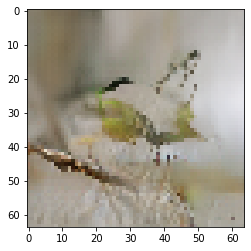

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 55

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.84450387954712 sec
Gen loss: 4.3887599031453535, Gen valid loss: 1.2728438461376077, Gen attr loss: 1.5871113354597635, Gen caption loss: 1.5288047370548816, Disc valid loss: 1.102998456980801, Disc valid real loss: 0.5566785712713794, Disc valid fake loss: 0.5463198829634079, Disc attr loss: 2.79662881084897, Disc attr real loss: 1.2095174753892066, Disc attr fake loss: 1.5871113354597635
Time for epoch 2 is 39.837944984436035 sec
Gen loss: 4.394353169412794, Gen valid loss: 1.2692688380476582, Gen attr loss: 1.5921900821572075, Gen caption loss: 1.5328942463003845, Disc valid loss: 1.0968575837812449, Disc valid real loss: 0.5558761857389435, Disc valid fake loss: 0.5409813981230666, Disc attr loss: 2.8021949405269573, Disc attr real loss: 1.2100048583697498, Disc attr fake loss: 1.5921900821572075
Time for epoch 3 is 39.8543541431427 sec
Gen los

Time for epoch 21 is 39.79855966567993 sec
Gen loss: 4.389162513944838, Gen valid loss: 1.2730722004159034, Gen attr loss: 1.5867350511757663, Gen caption loss: 1.5293552600917455, Disc valid loss: 1.096872148798087, Disc valid real loss: 0.5560707663940544, Disc valid fake loss: 0.5408013824040327, Disc attr loss: 2.7957943608444236, Disc attr real loss: 1.2090593096686573, Disc attr fake loss: 1.5867350511757663
Time for epoch 22 is 40.08074688911438 sec
Gen loss: 4.378654589821006, Gen valid loss: 1.2625113909806662, Gen attr loss: 1.5884730954803425, Gen caption loss: 1.5276701004524542, Disc valid loss: 1.1046491111843244, Disc valid real loss: 0.5596528449840339, Disc valid fake loss: 0.5449962660387603, Disc attr loss: 2.7970620492286473, Disc attr real loss: 1.208588953748305, Disc attr fake loss: 1.5884730954803425
Time for epoch 23 is 39.786104679107666 sec
Gen loss: 4.392501635926203, Gen valid loss: 1.273402910730057, Gen attr loss: 1.5878395113518569, Gen caption loss: 1.5

Time for epoch 41 is 39.738463163375854 sec
Gen loss: 4.385667823517549, Gen valid loss: 1.2654727642452168, Gen attr loss: 1.589170436548993, Gen caption loss: 1.5310246140007082, Disc valid loss: 1.1019585601036466, Disc valid real loss: 0.561097855005807, Disc valid fake loss: 0.5408607053401348, Disc attr loss: 2.7983186824858026, Disc attr real loss: 1.20914824593681, Disc attr fake loss: 1.589170436548993
Time for epoch 42 is 39.779465198516846 sec
Gen loss: 4.39731430813549, Gen valid loss: 1.275606480717336, Gen attr loss: 1.587958575910346, Gen caption loss: 1.5337492453696604, Disc valid loss: 1.0937591708772552, Disc valid real loss: 0.5539655011843859, Disc valid fake loss: 0.539793672035057, Disc attr loss: 2.7980855244608107, Disc attr real loss: 1.2101269485504647, Disc attr fake loss: 1.587958575910346
Time for epoch 43 is 39.77208161354065 sec
Gen loss: 4.384555636382684, Gen valid loss: 1.267935056673479, Gen attr loss: 1.5847621594018084, Gen caption loss: 1.53185841

Time for epoch 61 is 39.92700242996216 sec
Gen loss: 4.382536030720243, Gen valid loss: 1.2618146441816314, Gen attr loss: 1.5901081345591765, Gen caption loss: 1.530613247295059, Disc valid loss: 1.105516715747554, Disc valid real loss: 0.5595347181891361, Disc valid fake loss: 0.5459819999006059, Disc attr loss: 2.7996532508351293, Disc attr real loss: 1.2095451162759527, Disc attr fake loss: 1.5901081345591765
Time for epoch 62 is 39.94500279426575 sec
Gen loss: 4.397164457858739, Gen valid loss: 1.2683964835272894, Gen attr loss: 1.5938126976250957, Gen caption loss: 1.5349552757371732, Disc valid loss: 1.0997840256548832, Disc valid real loss: 0.5582425856008763, Disc valid fake loss: 0.5415414371464634, Disc attr loss: 2.803675238517565, Disc attr real loss: 1.2098625408924693, Disc attr fake loss: 1.5938126976250957
Time for epoch 63 is 39.980905532836914 sec
Gen loss: 4.386203198575069, Gen valid loss: 1.268600780789445, Gen attr loss: 1.5893082609021567, Gen caption loss: 1.52

Time for epoch 81 is 39.72777700424194 sec
Gen loss: 4.387832978230505, Gen valid loss: 1.264200009627717, Gen attr loss: 1.5918831256670034, Gen caption loss: 1.5317498358284556, Disc valid loss: 1.1056660100373472, Disc valid real loss: 0.5624538691547828, Disc valid fake loss: 0.543212142094041, Disc attr loss: 2.802116980074544, Disc attr real loss: 1.2102338544075406, Disc attr fake loss: 1.5918831256670034
Time for epoch 82 is 40.10235071182251 sec
Gen loss: 4.399490416534548, Gen valid loss: 1.278132821324718, Gen attr loss: 1.589053299691942, Gen caption loss: 1.5323043095710154, Disc valid loss: 1.0967526479465206, Disc valid real loss: 0.556523751841005, Disc valid fake loss: 0.5402288941671531, Disc attr loss: 2.797606374513166, Disc attr real loss: 1.208553074821224, Disc attr fake loss: 1.589053299691942
Time for epoch 83 is 39.79887819290161 sec
Gen loss: 4.390042650021188, Gen valid loss: 1.2766100956495539, Gen attr loss: 1.5853100013603687, Gen caption loss: 1.52812254

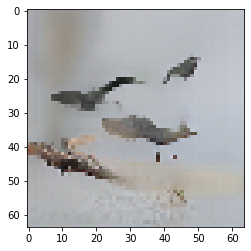

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 56

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.79872465133667 sec
Gen loss: 4.391023162903824, Gen valid loss: 1.271371661162958, Gen attr loss: 1.5897085834647904, Gen caption loss: 1.5299429234450426, Disc valid loss: 1.1019529782659638, Disc valid real loss: 0.5553615368640197, Disc valid fake loss: 0.546591442855716, Disc attr loss: 2.7994474009446657, Disc attr real loss: 1.2097388174798753, Disc attr fake loss: 1.5897085834647904
Time for epoch 2 is 39.824459075927734 sec
Gen loss: 4.3864233913783455, Gen valid loss: 1.2667104936227567, Gen attr loss: 1.58781651720445, Gen caption loss: 1.531896379581958, Disc valid loss: 1.0969051862473733, Disc valid real loss: 0.5565095620588235, Disc valid fake loss: 0.5403956266922679, Disc attr loss: 2.7962146315794327, Disc attr real loss: 1.2083981143749827, Disc attr fake loss: 1.58781651720445
Time for epoch 3 is 39.82793998718262 sec
Gen loss: 

Time for epoch 21 is 39.780004024505615 sec
Gen loss: 4.389899118805966, Gen valid loss: 1.2671511871058767, Gen attr loss: 1.591802925921391, Gen caption loss: 1.5309450038403354, Disc valid loss: 1.1007951242813896, Disc valid real loss: 0.5541400374758857, Disc valid fake loss: 0.5466550910052891, Disc attr loss: 2.7993245292808306, Disc attr real loss: 1.2075216033594396, Disc attr fake loss: 1.591802925921391
Time for epoch 22 is 39.781697034835815 sec
Gen loss: 4.386730079082293, Gen valid loss: 1.2704564169816532, Gen attr loss: 1.5885563552541138, Gen caption loss: 1.5277173231610761, Disc valid loss: 1.0995594776742827, Disc valid real loss: 0.557381630993794, Disc valid fake loss: 0.5421778458728377, Disc attr loss: 2.7978236308588893, Disc attr real loss: 1.2092672756047753, Disc attr fake loss: 1.5885563552541138
Time for epoch 23 is 39.90384316444397 sec
Gen loss: 4.361598575664407, Gen valid loss: 1.247238443472844, Gen attr loss: 1.5856061227276397, Gen caption loss: 1.5

Time for epoch 41 is 39.98790907859802 sec
Gen loss: 4.403401465273808, Gen valid loss: 1.2654790363014552, Gen attr loss: 1.5952520205722591, Gen caption loss: 1.542670394346966, Disc valid loss: 1.1041625263245125, Disc valid real loss: 0.559691108177671, Disc valid fake loss: 0.5444714149970026, Disc attr loss: 2.804908736288386, Disc attr real loss: 1.2096567157161269, Disc attr fake loss: 1.5952520205722591
Time for epoch 42 is 39.93922472000122 sec
Gen loss: 4.3846381957614975, Gen valid loss: 1.2642467777903488, Gen attr loss: 1.5877576268462308, Gen caption loss: 1.5326337901557363, Disc valid loss: 1.100596500121481, Disc valid real loss: 0.558650385881181, Disc valid fake loss: 0.54194611028281, Disc attr loss: 2.7967113430907085, Disc attr real loss: 1.208953716244478, Disc attr fake loss: 1.5877576268462308
Time for epoch 43 is 39.92190742492676 sec
Gen loss: 4.40251347172228, Gen valid loss: 1.2806872458961922, Gen attr loss: 1.5900531710001835, Gen caption loss: 1.5317730

Time for epoch 61 is 39.70667314529419 sec
Gen loss: 4.413706928087767, Gen valid loss: 1.27847294416531, Gen attr loss: 1.5975837671982887, Gen caption loss: 1.5376502178548797, Disc valid loss: 1.099096068198765, Disc valid real loss: 0.5586435609070589, Disc valid fake loss: 0.5404525056764039, Disc attr loss: 2.8059791462208197, Disc attr real loss: 1.208395379022531, Disc attr fake loss: 1.5975837671982887
Time for epoch 62 is 39.7637984752655 sec
Gen loss: 4.406578319182564, Gen valid loss: 1.277448633660469, Gen attr loss: 1.5950965464599733, Gen caption loss: 1.53403314568486, Disc valid loss: 1.094013029805367, Disc valid real loss: 0.5511523373727876, Disc valid fake loss: 0.5428606930787001, Disc attr loss: 2.8044850289983154, Disc attr real loss: 1.209388482538342, Disc attr fake loss: 1.5950965464599733
Time for epoch 63 is 39.72451877593994 sec
Gen loss: 4.381320834482912, Gen valid loss: 1.2613218749764812, Gen attr loss: 1.590773153434278, Gen caption loss: 1.5292258017

Time for epoch 81 is 39.949771881103516 sec
Gen loss: 4.40320584702944, Gen valid loss: 1.2742397899873212, Gen attr loss: 1.590468952649331, Gen caption loss: 1.5384971006775936, Disc valid loss: 1.0980118876550256, Disc valid real loss: 0.5564321158378105, Disc valid fake loss: 0.5415797740786379, Disc attr loss: 2.7959569439009275, Disc attr real loss: 1.2054879912515966, Disc attr fake loss: 1.590468952649331
Time for epoch 82 is 39.94141745567322 sec
Gen loss: 4.404643048438922, Gen valid loss: 1.277494379336918, Gen attr loss: 1.5893570769446974, Gen caption loss: 1.5377915900574144, Disc valid loss: 1.094169656758709, Disc valid real loss: 0.5511892258636351, Disc valid fake loss: 0.5429804295220673, Disc attr loss: 2.796186568452737, Disc attr real loss: 1.2068294915080393, Disc attr fake loss: 1.5893570769446974
Time for epoch 83 is 39.97959542274475 sec
Gen loss: 4.392210512626462, Gen valid loss: 1.2648219227144712, Gen attr loss: 1.5914579545902365, Gen caption loss: 1.5359

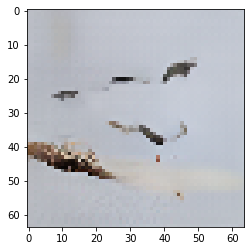

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 57

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.98443865776062 sec
Gen loss: 4.394334909392566, Gen valid loss: 1.276213973195249, Gen attr loss: 1.5876948927153094, Gen caption loss: 1.530426042835887, Disc valid loss: 1.0992654116173102, Disc valid real loss: 0.5591187348695306, Disc valid fake loss: 0.5401466758593634, Disc attr loss: 2.79604620694468, Disc attr real loss: 1.2083513142293707, Disc attr fake loss: 1.5876948927153094
Time for epoch 2 is 39.93447232246399 sec
Gen loss: 4.40379012438663, Gen valid loss: 1.2792390069664332, Gen attr loss: 1.5907119441484694, Gen caption loss: 1.5338391844173112, Disc valid loss: 1.0966169330162732, Disc valid real loss: 0.556751824249097, Disc valid fake loss: 0.5398651075556995, Disc attr loss: 2.800158822924141, Disc attr real loss: 1.2094468787756716, Disc attr fake loss: 1.5907119441484694
Time for epoch 3 is 39.945146322250366 sec
Gen loss: 4

Time for epoch 21 is 39.969990491867065 sec
Gen loss: 4.4000338609948715, Gen valid loss: 1.2731955870380247, Gen attr loss: 1.590960954909079, Gen caption loss: 1.5358773163017543, Disc valid loss: 1.1056362857340474, Disc valid real loss: 0.5633109744971361, Disc valid fake loss: 0.5423253113176765, Disc attr loss: 2.7971390823361673, Disc attr real loss: 1.2061781274270882, Disc attr fake loss: 1.590960954909079
Time for epoch 22 is 39.98610281944275 sec
Gen loss: 4.374061397743742, Gen valid loss: 1.264187180899023, Gen attr loss: 1.5829777830661473, Gen caption loss: 1.5268964337785715, Disc valid loss: 1.102084582898675, Disc valid real loss: 0.5566439772362954, Disc valid fake loss: 0.5454406029971312, Disc attr loss: 2.7918477778835347, Disc attr real loss: 1.2088699948173875, Disc attr fake loss: 1.5829777830661473
Time for epoch 23 is 39.94809889793396 sec
Gen loss: 4.38630426543838, Gen valid loss: 1.2589127776745535, Gen attr loss: 1.5919141901863947, Gen caption loss: 1.53

Time for epoch 41 is 40.115933656692505 sec
Gen loss: 4.404637982851767, Gen valid loss: 1.2836902968605683, Gen attr loss: 1.5919274120796016, Gen caption loss: 1.5290202832803494, Disc valid loss: 1.0962342724890566, Disc valid real loss: 0.557050991429869, Disc valid fake loss: 0.5391832804938319, Disc attr loss: 2.7991470172799375, Disc attr real loss: 1.2072196052003359, Disc attr fake loss: 1.5919274120796016
Time for epoch 42 is 40.10915207862854 sec
Gen loss: 4.417259072869774, Gen valid loss: 1.2894500891367595, Gen attr loss: 1.5932903037807806, Gen caption loss: 1.534518665091455, Disc valid loss: 1.0921050379592874, Disc valid real loss: 0.5496486980256027, Disc valid fake loss: 0.5424563401759801, Disc attr loss: 2.8007234095880977, Disc attr real loss: 1.2074331058073173, Disc attr fake loss: 1.5932903037807806
Time for epoch 43 is 40.15103340148926 sec
Gen loss: 4.3991190973659196, Gen valid loss: 1.2835064438300403, Gen attr loss: 1.587099552154541, Gen caption loss: 1.

Time for epoch 61 is 40.173561334609985 sec
Gen loss: 4.4089521108281, Gen valid loss: 1.2720858902142946, Gen attr loss: 1.5962317345265127, Gen caption loss: 1.5406344799491447, Disc valid loss: 1.1005935859550953, Disc valid real loss: 0.5574402322937156, Disc valid fake loss: 0.5431533497038895, Disc attr loss: 2.8049526146756922, Disc attr real loss: 1.2087208801491798, Disc attr fake loss: 1.5962317345265127
Time for epoch 62 is 40.1248676776886 sec
Gen loss: 4.4111941907464, Gen valid loss: 1.2782820563329267, Gen attr loss: 1.5960197765329667, Gen caption loss: 1.5368923750027086, Disc valid loss: 1.0924482688025083, Disc valid real loss: 0.5565820381570314, Disc valid fake loss: 0.535866231453128, Disc attr loss: 2.804200578511246, Disc attr real loss: 1.2081808019782792, Disc attr fake loss: 1.5960197765329667
Time for epoch 63 is 40.1135368347168 sec
Gen loss: 4.398057322515059, Gen valid loss: 1.2800277079023965, Gen attr loss: 1.5867262616713196, Gen caption loss: 1.531303

Time for epoch 81 is 40.09411692619324 sec
Gen loss: 4.412608822509848, Gen valid loss: 1.2915005239690869, Gen attr loss: 1.5899320017031537, Gen caption loss: 1.5311762989375004, Disc valid loss: 1.0890365743701698, Disc valid real loss: 0.550868637758865, Disc valid fake loss: 0.5381679342691168, Disc attr loss: 2.7967375626732016, Disc attr real loss: 1.2068055609700479, Disc attr fake loss: 1.5899320017031537
Time for epoch 82 is 40.125792264938354 sec
Gen loss: 4.404958345056549, Gen valid loss: 1.2845571406165435, Gen attr loss: 1.5888480264643021, Gen caption loss: 1.5315531857291533, Disc valid loss: 1.0964151604711847, Disc valid real loss: 0.5533020440640488, Disc valid fake loss: 0.5431131155994849, Disc attr loss: 2.7947447826545737, Disc attr real loss: 1.2058967561902716, Disc attr fake loss: 1.5888480264643021
Time for epoch 83 is 40.109991788864136 sec
Gen loss: 4.391068248567866, Gen valid loss: 1.2706381025999218, Gen attr loss: 1.5873949957410818, Gen caption loss: 

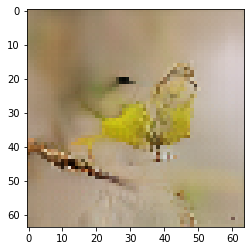

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 58

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 39.9827823638916 sec
Gen loss: 4.392296130741192, Gen valid loss: 1.2688092203321173, Gen attr loss: 1.5913470127395175, Gen caption loss: 1.5321398925005905, Disc valid loss: 1.1005433024106632, Disc valid real loss: 0.5587771716641217, Disc valid fake loss: 0.5417661276774678, Disc attr loss: 2.7957927143670678, Disc attr real loss: 1.2044457016275505, Disc attr fake loss: 1.5913470127395175
Time for epoch 2 is 40.205780029296875 sec
Gen loss: 4.3904325393480335, Gen valid loss: 1.2782536556081074, Gen attr loss: 1.5839279864215592, Gen caption loss: 1.5282508897264475, Disc valid loss: 1.0972642888867759, Disc valid real loss: 0.5499375463339694, Disc valid fake loss: 0.5473267444911688, Disc attr loss: 2.7902099499857522, Disc attr real loss: 1.206281963564193, Disc attr fake loss: 1.5839279864215592
Time for epoch 3 is 40.24662256240845 sec
Gen l

Time for epoch 21 is 40.2335786819458 sec
Gen loss: 4.414088975446334, Gen valid loss: 1.288673856717138, Gen attr loss: 1.590835757371856, Gen caption loss: 1.534579364587944, Disc valid loss: 1.097148445886648, Disc valid real loss: 0.5584339845955857, Disc valid fake loss: 0.538714463229425, Disc attr loss: 2.795344930677233, Disc attr real loss: 1.204509173305377, Disc attr fake loss: 1.590835757371856
Time for epoch 22 is 40.20333743095398 sec
Gen loss: 4.388292667988516, Gen valid loss: 1.2702212281989533, Gen attr loss: 1.5897877478018039, Gen caption loss: 1.528283693926121, Disc valid loss: 1.0995141416384275, Disc valid real loss: 0.5590708896235076, Disc valid fake loss: 0.5404432500765576, Disc attr loss: 2.7951787660115457, Disc attr real loss: 1.2053910182097416, Disc attr fake loss: 1.5897877478018039
Time for epoch 23 is 40.19132447242737 sec
Gen loss: 4.400740864477183, Gen valid loss: 1.2811176247066922, Gen attr loss: 1.5889672196008326, Gen caption loss: 1.530656020

Time for epoch 41 is 40.125272274017334 sec
Gen loss: 4.401347796122233, Gen valid loss: 1.2815792098601013, Gen attr loss: 1.5908473591171306, Gen caption loss: 1.5289212132534038, Disc valid loss: 1.1013567749723832, Disc valid real loss: 0.5567794631974807, Disc valid fake loss: 0.5445773124210234, Disc attr loss: 2.7958095299842234, Disc attr real loss: 1.2049621708670928, Disc attr fake loss: 1.5908473591171306
Time for epoch 42 is 40.154502391815186 sec
Gen loss: 4.378798824661793, Gen valid loss: 1.2661981978390597, Gen attr loss: 1.585822459481919, Gen caption loss: 1.5267781639486793, Disc valid loss: 1.098258281303292, Disc valid real loss: 0.553793964266454, Disc valid fake loss: 0.544464319379026, Disc attr loss: 2.7907405847779456, Disc attr real loss: 1.2049181252960268, Disc attr fake loss: 1.585822459481919
Time for epoch 43 is 40.10723257064819 sec
Gen loss: 4.401989669334598, Gen valid loss: 1.2766155899378666, Gen attr loss: 1.5894306348914375, Gen caption loss: 1.53

Time for epoch 61 is 40.1090567111969 sec
Gen loss: 4.371751437665324, Gen valid loss: 1.2529942900507753, Gen attr loss: 1.5868966253146246, Gen caption loss: 1.5318605105082195, Disc valid loss: 1.1096564550709918, Disc valid real loss: 0.5628357337419256, Disc valid fake loss: 0.5468207206829454, Disc attr loss: 2.7919865142362226, Disc attr real loss: 1.2050898889215982, Disc attr fake loss: 1.5868966253146246
Time for epoch 62 is 40.118040323257446 sec
Gen loss: 4.3850349371995385, Gen valid loss: 1.262842374765453, Gen attr loss: 1.588877324489397, Gen caption loss: 1.5333152466673192, Disc valid loss: 1.0993989536432716, Disc valid real loss: 0.558107548370594, Disc valid fake loss: 0.5412914054342078, Disc attr loss: 2.792348703717798, Disc attr real loss: 1.2034713792284006, Disc attr fake loss: 1.588877324489397
Time for epoch 63 is 40.140639305114746 sec
Gen loss: 4.367470577157286, Gen valid loss: 1.253429781292189, Gen attr loss: 1.5850838044794595, Gen caption loss: 1.528

Time for epoch 81 is 40.14808201789856 sec
Gen loss: 4.389356041988383, Gen valid loss: 1.2696930974479612, Gen attr loss: 1.5889866022559684, Gen caption loss: 1.5306763384077284, Disc valid loss: 1.101961902002009, Disc valid real loss: 0.5594498061229219, Disc valid fake loss: 0.5425120978174494, Disc attr loss: 2.795329986225945, Disc attr real loss: 1.2063433839699764, Disc attr fake loss: 1.5889866022559684
Time for epoch 82 is 40.09291887283325 sec
Gen loss: 4.386465205732723, Gen valid loss: 1.2707053568305038, Gen attr loss: 1.5872481376498049, Gen caption loss: 1.5285117044681455, Disc valid loss: 1.0981203991223156, Disc valid real loss: 0.560257971529069, Disc valid fake loss: 0.5378624261394749, Disc attr loss: 2.7920893983143134, Disc attr real loss: 1.2048412606645083, Disc attr fake loss: 1.5872481376498049
Time for epoch 83 is 40.11645030975342 sec
Gen loss: 4.374378593956552, Gen valid loss: 1.259683010216328, Gen attr loss: 1.586862499474833, Gen caption loss: 1.5278

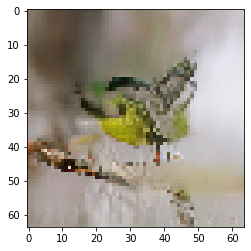

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 59

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 40.11821913719177 sec
Gen loss: 4.396746705218059, Gen valid loss: 1.2773578972997381, Gen attr loss: 1.5903597782620893, Gen caption loss: 1.5290290214181916, Disc valid loss: 1.0951837606546355, Disc valid real loss: 0.5566334272949354, Disc valid fake loss: 0.5385503314213378, Disc attr loss: 2.7958926335582888, Disc attr real loss: 1.2055328552961995, Disc attr fake loss: 1.5903597782620893
Time for epoch 2 is 40.15794014930725 sec
Gen loss: 4.395342864318269, Gen valid loss: 1.2802073348182326, Gen attr loss: 1.586937971231414, Gen caption loss: 1.5281975624684072, Disc valid loss: 1.0908929571549744, Disc valid real loss: 0.552026980937658, Disc valid fake loss: 0.5388659724213567, Disc attr loss: 2.794709543225565, Disc attr real loss: 1.2077715719941509, Disc attr fake loss: 1.586937971231414
Time for epoch 3 is 40.08895945549011 sec
Gen loss:

Time for epoch 21 is 40.101874351501465 sec
Gen loss: 4.394033096670135, Gen valid loss: 1.2663453303701508, Gen attr loss: 1.5904108344054804, Gen caption loss: 1.5372769393248933, Disc valid loss: 1.1046885925579846, Disc valid real loss: 0.5593754011925643, Disc valid fake loss: 0.5453131899116485, Disc attr loss: 2.795119730276144, Disc attr real loss: 1.2047088958706635, Disc attr fake loss: 1.5904108344054804
Time for epoch 22 is 40.145575284957886 sec
Gen loss: 4.393982974494376, Gen valid loss: 1.2659050872332358, Gen attr loss: 1.5918942353912808, Gen caption loss: 1.5361836570388256, Disc valid loss: 1.1025148557453621, Disc valid real loss: 0.560694330268436, Disc valid fake loss: 0.5418205249923355, Disc attr loss: 2.7986895721456224, Disc attr real loss: 1.2067953367543414, Disc attr fake loss: 1.5918942353912808
Time for epoch 23 is 40.14210915565491 sec
Gen loss: 4.390541569650335, Gen valid loss: 1.265648368251356, Gen attr loss: 1.5898920714370604, Gen caption loss: 1.

Time for epoch 41 is 40.13919448852539 sec
Gen loss: 4.373734703555017, Gen valid loss: 1.2592506838361746, Gen attr loss: 1.5871015509292685, Gen caption loss: 1.5273824671742715, Disc valid loss: 1.1084819135627126, Disc valid real loss: 0.5635764070642673, Disc valid fake loss: 0.5449055066599755, Disc attr loss: 2.7928660736497504, Disc attr real loss: 1.2057645227204816, Disc attr fake loss: 1.5871015509292685
Time for epoch 42 is 40.144498109817505 sec
Gen loss: 4.392639123327363, Gen valid loss: 1.2744242277571824, Gen attr loss: 1.5870609609738275, Gen caption loss: 1.5311539334656423, Disc valid loss: 1.0970969718646228, Disc valid real loss: 0.5535278359079748, Disc valid fake loss: 0.5435691361989432, Disc attr loss: 2.7918398074987456, Disc attr real loss: 1.2047788465249183, Disc attr fake loss: 1.5870609609738275
Time for epoch 43 is 40.14532256126404 sec
Gen loss: 4.395133882357176, Gen valid loss: 1.2694738641340881, Gen attr loss: 1.5913290463811982, Gen caption loss: 

Time for epoch 61 is 40.17144250869751 sec
Gen loss: 4.400397516524565, Gen valid loss: 1.2764807555087536, Gen attr loss: 1.5912413590645726, Gen caption loss: 1.5326754029204206, Disc valid loss: 1.099553300274743, Disc valid real loss: 0.5532684467510802, Disc valid fake loss: 0.5462848545736091, Disc attr loss: 2.794451097485819, Disc attr real loss: 1.2032097384212463, Disc attr fake loss: 1.5912413590645726
Time for epoch 62 is 40.12888550758362 sec
Gen loss: 4.3943051930042465, Gen valid loss: 1.2715321042673375, Gen attr loss: 1.5903941118297216, Gen caption loss: 1.5323789924140867, Disc valid loss: 1.0953438710067978, Disc valid real loss: 0.5549340691508317, Disc valid fake loss: 0.5404098012098452, Disc attr loss: 2.7949878137286115, Disc attr real loss: 1.2045937018988901, Disc attr fake loss: 1.5903941118297216
Time for epoch 63 is 40.10422873497009 sec
Gen loss: 4.408980341138555, Gen valid loss: 1.2786942137289177, Gen attr loss: 1.5928030463092049, Gen caption loss: 1.

Time for epoch 81 is 40.11968541145325 sec
Gen loss: 4.4058450243983485, Gen valid loss: 1.2836939388820472, Gen attr loss: 1.5896878578475497, Gen caption loss: 1.5324632378451546, Disc valid loss: 1.0898855225180546, Disc valid real loss: 0.5517992051797831, Disc valid fake loss: 0.5380863167729159, Disc attr loss: 2.7930014758575252, Disc attr real loss: 1.2033136180099757, Disc attr fake loss: 1.5896878578475497
Time for epoch 82 is 40.1200966835022 sec
Gen loss: 4.409620942139044, Gen valid loss: 1.2872260020677313, Gen attr loss: 1.5884060992134943, Gen caption loss: 1.5339888373041541, Disc valid loss: 1.0927233390691804, Disc valid real loss: 0.5521586978338598, Disc valid fake loss: 0.5405646418814414, Disc attr loss: 2.795311235476962, Disc attr real loss: 1.2069051362634675, Disc attr fake loss: 1.5884060992134943
Time for epoch 83 is 40.10805869102478 sec
Gen loss: 4.389757310794944, Gen valid loss: 1.2684661413272869, Gen attr loss: 1.5859872787625486, Gen caption loss: 1.

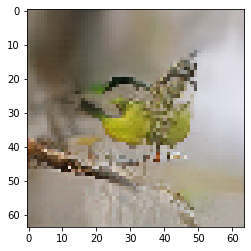

In [82]:
next_starting_checkpoint, totalepochs, warmup = long_train(starting_checkpoint=next_starting_checkpoint, 
                                      num_checkpoints=20, 
                                      checkpoint_interval=100, 
                                      g_hist=gen_loss_hist, 
                                      g_valid_hist=gen_valid_loss_hist,
                                      g_attr_hist=gen_attr_loss_hist,
                                      g_caption_hist=gen_caption_loss_hist,
                                      d_hist=disc_loss_hist,
                                      d_real_hist=disc_loss_real_hist,
                                      d_fake_hist=disc_loss_fake_hist,
                                      d_attr_real_hist=disc_attr_loss_real_hist,
                                      d_attr_fake_hist=disc_attr_loss_fake_hist,
                                      noise=noise300,
                                      caption=caption,
                                      save_files=True,
                                      warmup=warmup)

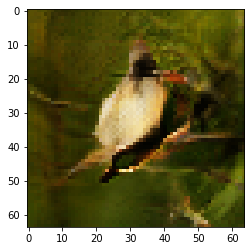

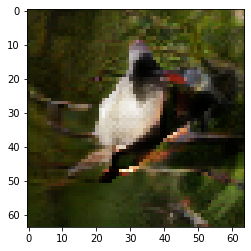

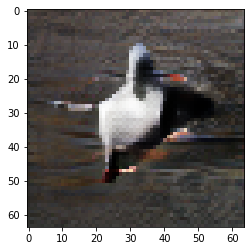

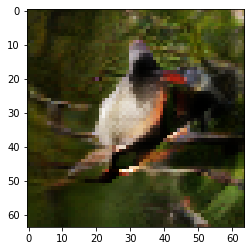

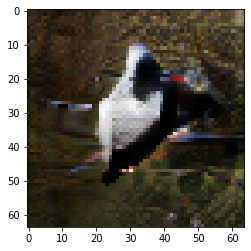

In [189]:
captions = train_captions[np.random.choice(range(len(train_captions)), 5, replace=False)]
# attrs = [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
tempnoise = np.random.normal(0, 1, 300)
for i in range(5):
#     tempnoise = np.random.normal(0, 1, 300)

    
#     attrs[2] += 1.
    
    generated_image = generator.predict([np.array([tempnoise]), np.array([1.*captions[i]])] )[0][0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()
#     ax.imshow(unnormalize_img(generated_image))

In [ ]:
caption = bc.encode(['the medium sized bird has a dark grey color, a black downward curved beak, and long wings.'])[0]
noise = np.random.normal(0, 1, 300)
for i in range(1):
    generated_image = generator.predict([np.array([noise]), np.array([1.*caption])] )[0][0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()
#     ax.imshow(unnormalize_img(generated_image))

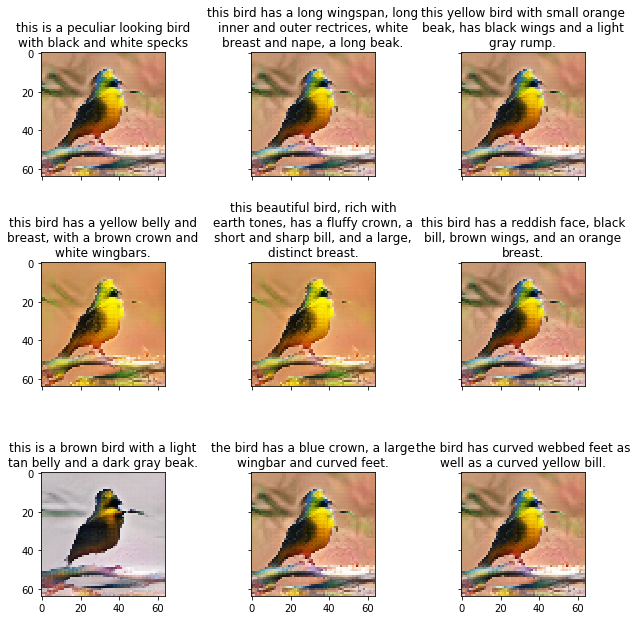

In [182]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=1.2,  # pad between axes in inch.
                 )

indices = np.random.choice(len(train_captions), 9)
captions = train_captions[indices]
text = [caption_text[x] for x in indices]
tempnoise = np.random.normal(0, 1, 300)
for i, ax in enumerate(grid):
    generated_image = generator.predict([np.array([tempnoise]), np.array([captions[i]])] )[0][0]
    ax.imshow(unnormalize_img(generated_image))
    ax.set_title('\n'.join(wrap(text[i], 35)))

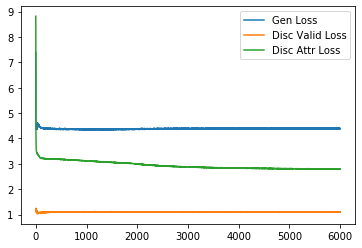

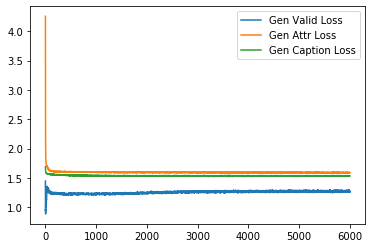

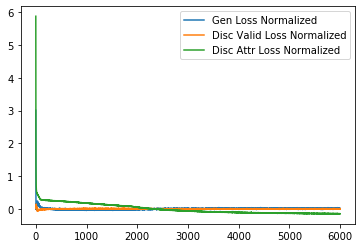

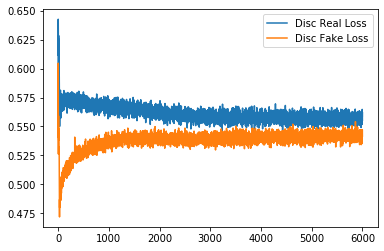

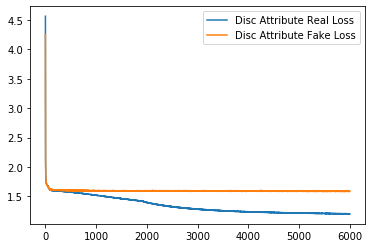

In [83]:
plot_save_dir = 'bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-balanced'

from operator import add
disc_attr_loss_hist = list( map(add, disc_attr_loss_real_hist, disc_attr_loss_fake_hist) )

plt.plot(gen_loss_hist)
plt.plot(disc_loss_hist)
plt.plot(disc_attr_loss_hist)

plt.legend(['Gen Loss','Disc Valid Loss', 'Disc Attr Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/g_d_losses.png')
plt.show()

plt.plot(gen_valid_loss_hist)
plt.plot(gen_attr_loss_hist)
plt.plot(gen_caption_loss_hist)
plt.legend(['Gen Valid Loss', 'Gen Attr Loss', 'Gen Caption Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/g_valid_attr_losses.png')
plt.show()

plt.plot(gen_loss_hist - np.mean(gen_loss_hist))
plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
plt.plot(disc_attr_loss_hist - np.mean(disc_attr_loss_hist))
plt.legend(['Gen Loss Normalized','Disc Valid Loss Normalized', 'Disc Attr Loss Normalized'])
plt.savefig('./results/plots/'+plot_save_dir+'/g_d_losses_normalized.png')
plt.show()

plt.plot(disc_loss_real_hist)
plt.plot(disc_loss_fake_hist)
plt.legend(['Disc Real Loss','Disc Fake Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/d_real_fake_losses.png')
plt.show()

plt.plot(disc_attr_loss_real_hist)
# plt.show()
plt.plot(disc_attr_loss_fake_hist)
plt.legend(['Disc Attribute Real Loss', 'Disc Attribute Fake Loss'])
plt.savefig('./results/plots/'+plot_save_dir+'/d_attribute_real_fake_losses.png')
plt.show()


In [ ]:
prediction = discriminator_attr.predict(np.array([train_imgs[6]]))[0]
print(np.where(np.round(prediction) == 1))

In [ ]:
prediction = discriminator_attr.predict(np.array([train_imgs[344]]))[0]
print(np.where(np.round(prediction) == 1))

In [ ]:
d = dict.fromkeys([i for i in range(10)], 0)
prediction = discriminator_attr.predict(np.array(train_imgs))
prediction = np.round(prediction)
for p in prediction:
    p = np.where(p == 1)
    for i in p[0]:
        d[i] += 1
    
# for im in train_imgs:
#     for p in prediction[0]:
#         d[p] += 1

In [ ]:
plt.bar([x for x in range(10)], d.values())

In [ ]:
plt.bar([x for x in range(10)], np.sum(train_attrs, axis=0))

In [ ]:
train_captions[0]

In [ ]:
from bert_serving.client import BertClient
bc = BertClient()

In [ ]:
testcaption = bc.encode(['red bird.'])[0]

In [ ]:
testcaption[0][0]


In [19]:
generator.load_weights('./results/weights/bird-gan-attributes-split-captions-concat-caption-loss-autoencoder-34-balanced/gen_weights_attributes_split_2000.h5')

del train_imgs

fid_imgs = []
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    for name in files:
        im = cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR)
        im = cv2.resize(im, (299, 299))
        fid_imgs.append(im)

fid_imgs = np.array(fid_imgs)
fid_imgs = fid_imgs[5894:]
# fid_imgs = (fid_imgs - 127.5)/127.5

train_captions = train_captions[5894:]

def generate_fake_images(model, samples, noise_dim):
    noise = np.random.normal(0, 1, (samples, noise_dim))
    imgs = model.predict([noise, train_captions])[0]
    resized_imgs = []
    for img in imgs:
        resized_imgs.append(cv2.resize(unnormalize_img(img), (299, 299)))
    return np.round(255*np.array(resized_imgs))


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
iv3 = InceptionV3(include_top=False, pooling='avg')#, input_shape=(75,75,3))

import scipy

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

fids = 0
for i in range(1):
    fake_images = generate_fake_images(generator, len(fid_imgs), 300)
    fids += calculate_fid(iv3, fid_imgs, fake_images)
    print(f'{100*(i+1)/5.:.2f}%')
print(fids/1.)

20.00%
52.31372603586996
